In [1]:
import sys
sys.path.append('/workspace/HRV')
from utils.imports import *
from utils.func import *
from utils.various_models import *
from utils.corr_vif import *
from utils.delete_feature import *

from utils.figure import *

In [2]:
another_target = ['PSS', 'AB' , 'CES', 'state_anx', 'BFI'] # FSS외 target 후보 변수
df = pd.read_csv('../../초반 코드/data1.csv')
df.columns = df.columns.str.replace(' ', '_')
df.drop(columns = '수진당시나이',inplace = True)
df.drop(columns = another_target, inplace = True)
print(df.columns)
df.drop(columns='피로도', inplace = True)
'''
cortisol 추가 시도 
해당 수치 없는 사람은 버리지 않고 mice 로 예측
'''
col_list = {'num_col': ['Age',  '자율신경 활성도',  '자율신경 균형도',  '스트레스 저항도',  '스트레스 지수',  '피로도',  '평균 심박동수',  '심장 안정도',  'Sdnn',  'Psi',  'Tp',  'Vlf',  'Lf',  'Hf',  'LfNorm',  'HfNorm',  'Lf/Hf',  'Rmssd',  'Apen',  'Srd',  'Tsrd',  'Tp(ln)',  'Vlf(ln)',  'Lf(ln)',  'Hf(ln)',  '수진당시나이',  '25-Hydroxy Vitamin D (Total)',  'Albumin',  'Free T4',  'GGT',  'GOT (AST)',  'GPT (ALT)',  'Glucose',  'Hb',  'HbA1c-NGSP',  'LDL-Cholesterol',  'TSH',  'TG',  'eGFR'],
 'cat_col': ['Sex', 'PSS', 'AB', 'FSS', 'CES', 'BFI'],
 'cat_col_ord': [],
 'label': ['state_anx'],
 'drop_col': ['ChartID',  'PersonalID',  '환자번호',  '측정센서',  '25-Hydroxy Vitamin D (D3/D2)',  '등록번호_확인',  'Date']}
res = pd.read_excel('../../초반 코드/HRV_Cortisol_241218.xlsx')
res_num = pd.read_excel('../../초반 코드/final_data.xlsx')
df['Chart_ID'] = res_num['ChartID']
df['Date'] = res_num['Date']
res_unique = res.drop_duplicates(subset=["환자번호", "검진 시행일자","검사 세부 항목명"], keep="first")
res_wide = res_unique.pivot(
    index=["환자번호", "검진 시행일자"],
    columns=["검사 세부 항목명"],
    values="검사결과"
).reset_index()
res_wide["Chart ID"] = res_wide.groupby("환자번호")["환자번호 <- 상부위장관 내시경(위) 결과지  <- 과별서식기본"].transform(lambda group: group.ffill().bfill())
columns = ["Chart ID"] + [col for col in res_wide.columns if col != "Chart ID"]  # 열 순서 정의
res_wide = res_wide[columns]
res_wide['Chart ID'] = res_wide['Chart ID'].astype('int64')
res_wide.columns = res_wide.columns.str.replace(' ', '_')
res_wide.columns = ['Chart_ID', '환자번호', '검진_시행일자','Cortisol(핵의학)','환자번호_<-_상부위장관_내시경(위)_결과지__<-_과별서식기본']
df['Date'] = pd.to_datetime(df['Date'])
merged_df = pd.merge(
    df, 
    res_wide[['Chart_ID', '검진_시행일자', 'Cortisol(핵의학)']], 
    left_on=['Chart_ID', 'Date'],
    right_on=['Chart_ID', '검진_시행일자'],
    how='left'  
)
merged_df.drop(columns = ['Date', 'Chart_ID','검진_시행일자'],inplace = True)
print(merged_df.shape)
col_list['num_col'].append('Cortisol(핵의학)')
nac = merged_df.isna().sum()
print(nac[nac > 0]) # nan값 없음
df = merged_df.copy()
blood = ['25-Hydroxy_Vitamin_D_(Total)','Albumin','Free_T4','GGT','GOT_(AST)','GPT_(ALT)','Glucose','Hb','HbA1c-NGSP','LDL-Cholesterol','TSH','TG']
df.drop(columns=blood, inplace = True)
print(df.columns)
num_cols=['Age','자율신경_활성도', '자율신경_균형도', '스트레스_저항도', '스트레스_지수', '평균_심박동수',
      '심장_안정도', 'Sdnn', 'Psi', 'Tp', 'Vlf', 'Lf', 'Hf', 'LfNorm', 'HfNorm',
      'Lf/Hf', 'Rmssd', 'Apen', 'Srd', 'Tsrd', 'Tp(ln)', 'Vlf(ln)', 'Lf(ln)',
      'Hf(ln)', 'eGFR','Cortisol(핵의학)']
cat_cols = ['Sex']
targets= ['BFI']
features = num_cols.copy()
df['Cortisol_missing'] = df['Cortisol(핵의학)'].isnull().astype(int) 

Index(['Age', 'Sex', '자율신경_활성도', '자율신경_균형도', '스트레스_저항도', '스트레스_지수', '피로도',
       '평균_심박동수', '심장_안정도', 'Sdnn', 'Psi', 'Tp', 'Vlf', 'Lf', 'Hf', 'LfNorm',
       'HfNorm', 'Lf/Hf', 'Rmssd', 'Apen', 'Srd', 'Tsrd', 'Tp(ln)', 'Vlf(ln)',
       'Lf(ln)', 'Hf(ln)', 'FSS', '25-Hydroxy_Vitamin_D_(Total)', 'Albumin',
       'Free_T4', 'GGT', 'GOT_(AST)', 'GPT_(ALT)', 'Glucose', 'Hb',
       'HbA1c-NGSP', 'LDL-Cholesterol', 'TSH', 'TG', 'eGFR'],
      dtype='object')
(336, 40)
Cortisol(핵의학)    108
dtype: int64
Index(['Age', 'Sex', '자율신경_활성도', '자율신경_균형도', '스트레스_저항도', '스트레스_지수', '평균_심박동수',
       '심장_안정도', 'Sdnn', 'Psi', 'Tp', 'Vlf', 'Lf', 'Hf', 'LfNorm', 'HfNorm',
       'Lf/Hf', 'Rmssd', 'Apen', 'Srd', 'Tsrd', 'Tp(ln)', 'Vlf(ln)', 'Lf(ln)',
       'Hf(ln)', 'FSS', 'eGFR', 'Cortisol(핵의학)'],
      dtype='object')


In [3]:
target = 'FSS'
X = df.drop(columns=target)
y = df[target] # FSS
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 확인: 각 데이터셋의 클래스 비율
print("Train class distribution:", y_train.value_counts(normalize=True));print(y_train.shape);print()
print("Test class distribution:", y_test.value_counts(normalize=True));print(y_test.shape);print()

Train class distribution: FSS
0    0.537313
1    0.462687
Name: proportion, dtype: float64
(268,)

Test class distribution: FSS
0    0.529412
1    0.470588
Name: proportion, dtype: float64
(68,)



 코르티솔 결측 그룹(108명)과 비결측 그룹(228명)의 시스템적 차이를 분석

#### 코드 목적
- 결측 데이터가 무작위로 발생했는지(MCAR) 판단

- 두 그룹 간 유의미한 차이 발견 → 결측 처리 방식 결정

- 논문에서 결측 처리 방식에 대한 과학적 근거 제시

In [6]:
contingency_table = pd.crosstab(df['Cortisol(핵의학)'].isnull(), df[target])
print("Contingency Table:")
display(contingency_table)

# 카이제곱 검정 수행 및 기대빈도 확인
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("\nExpected Frequencies:")
print(expected)
# 모든 셀의 기대빈도(만약 두 변수가 전혀 관련이 없다면, 이 셀에 이만큼의 표본수가 들어있을 것이다”라는 이론상(모형상) 예상값)가 5 이상이므로 카이제곱 검정을 실시할 수 있음.

# (False, FSS=0) 셀: 관측 100 vs 기대 122.14 → 관측이 기대보다 약 22명 적음
# (False, FSS=1) 셀: 관측 128 vs 기대 105.86 → 관측이 기대보다 약 22명 많음
# (True, FSS=0) 셀: 관측 80 vs 기대 57.86 → 관측이 기대보다 약 22명 많음
# (True, FSS=1) 셀: 관측 28 vs 기대 50.14 → 관측이 기대보다 약 22명 적음

# 즉,
# Cortisol=True 집단에서는 FSS=0인 사람이 예상보다 많고 FSS=1인 사람이 예상보다 적다.
# Cortisol=False 집단에서는 FSS=0인 사람이 예상보다 적고 FSS=1인 사람이 예상보다 많다.

print(f"\np_value: {p_value:.10f}")
# p-value가 0.05보다 작으므로 'Cortisol(핵의학)' 결측 여부와 'FSS' 간에는 통계적으로 유의미한 관계가 있다.
# 즉, 'Cortisol(핵의학)' 결측 여부는 'FSS'를 예측하는 데 도움이 될 수 있다.
# "두 변수 간의 관계가 없다"는 귀무가설을 기각할 수 있다.-> Cortisol 측정여부와 FSS는 통계적으로 유의미하게 관련이 있다고 해석

# p-value가 0.05 미만이라면:
# “Cortisol(핵의학) 검사가 True(즉, 검사받은)인 사람들은 FSS가 1(피로도가 높음)일 확률이 기대값(독립 가정하)보다 낮고,
# False(검사를 받지 않은) 사람들은 FSS가 1일 확률이 기대값보다 높다.”
# 이는 Cortisol 측정 여부와 피로도(FSS) 사이에 통계적으로 유의한 연관이 있음을 시사함.

Contingency Table:


FSS,0,1
Cortisol(핵의학),,
False,100,128
True,80,28



Expected Frequencies:
[[122.14285714 105.85714286]
 [ 57.85714286  50.14285714]]

p_value: 0.0000003993


In [7]:
contingency_table = pd.crosstab(df['Cortisol(핵의학)'].isnull(), df['Sex'])
print("Contingency Table:")
display(contingency_table)
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print("\nExpected Frequencies:")
print(expected)
# Sex 도 기대 빈도가 5 이상이므로 카이제곱 검정을 실시할 수 있음.
print(f"\np_value: {p_value:.10f}")
# p value가 0.05보다 크므로 두 변수는 독립적이다. -> 결측이랑 성별은 독립적이다.
# 일단 지금 범주형 변수들은 전부 카이제곱 검정을 해도 되는거임. 결측여부랑 관련있는건 타겟만 이지만

Contingency Table:


Sex,0,1
Cortisol(핵의학),,
False,134,94
True,57,51



Expected Frequencies:
[[129.60714286  98.39285714]
 [ 61.39285714  46.60714286]]

p_value: 0.3585583153


In [9]:
target = 'FSS'
cat = ['Sex', 'Cortisol_missing']
num = ['Age', '자율신경_활성도', '자율신경_균형도', '스트레스_저항도', '스트레스_지수', '평균_심박동수',    
       '심장_안정도', 'Sdnn', 'Psi', 'Tp', 'Vlf', 'Lf', 'Hf', 'LfNorm', 'HfNorm',       
       'Lf/Hf', 'Rmssd', 'Apen', 'Srd', 'Tsrd', 'Tp(ln)', 'Vlf(ln)', 'Lf(ln)','Hf(ln)', 'eGFR', 'Cortisol(핵의학)']    

In [10]:
# 수치형 변수에 대해서 t test 수행해도 되는지 확인
# 비정규분포에 가깝거나 이상치가 많으면 t test 가 왜곡될 수 있으므로 사전에 정규성 검정 이나 히스토그림/QQ plot으로 분포 형태 확인
missing_group = df[df['Cortisol(핵의학)'].isnull()]
non_missing_group = df[~df['Cortisol(핵의학)'].isnull()]

# missing_group의 정규성 검정을 수행
for i in num:
    # shapiro-wilk test : 표본이 정규분포로부터 추출되었는지 여부 확인하는 가설 검정
    # 귀무가설 : 표본은 정규분포를 따른다. / 대립가설 : 표본은 정규분포를 따르지 않는다.
    # p-value가 0.05보다 작으면 귀무가설 기각 -> 정규분포를 따르지 않는다.
    stat, p_value = shapiro(missing_group[i])
    if p_value < 0.05:
        print(f"{BRIGHT_BLUE}{i} missing group Shapiro-Wilk test p-value: {p_value:.10f}{BRIGHT_END}")
        print(f"{BRIGHT_BLACK}{i} missing group is not normally distributed.{BRIGHT_END}")
    else:
        print(f"{i} missing group Shapiro-Wilk test p-value: {p_value:.10f}")
        print(f"{BRIGHT_BLACK}{i} missing group is normally distributed.{BRIGHT_END}")
print('-'*50) 
# non_missing_group의 정규성 검정을 수행
for i in num:
    stat, p_value = shapiro(non_missing_group[i])
    if p_value < 0.05:
        print(f"{BRIGHT_BLUE}{i} non-missing group Shapiro-Wilk test p-value: {p_value:.10f}{BRIGHT_END}")
        print(f"{BRIGHT_BLACK}{i} non-missing group is not normally distributed.{BRIGHT_END}")
    else:
        print(f"{i} non-missing group Shapiro-Wilk test p-value: {p_value:.10f}")
        print(f"{BRIGHT_BLACK}{i} non-missing group is normally distributed.{BRIGHT_END}")
        
# missing_group 이던지 non_missing_group 이던지 정규성을 띄지 않는 변수가 많음 -> t test 사용 불가능

Age missing group Shapiro-Wilk test p-value: 0.0000007741
Age missing group is not normally distributed.
자율신경_활성도 missing group Shapiro-Wilk test p-value: 0.0005624563
자율신경_활성도 missing group is not normally distributed.
자율신경_균형도 missing group Shapiro-Wilk test p-value: 0.0001125868
자율신경_균형도 missing group is not normally distributed.
스트레스_저항도 missing group Shapiro-Wilk test p-value: 0.0005543589
스트레스_저항도 missing group is not normally distributed.
스트레스_지수 missing group Shapiro-Wilk test p-value: 0.0000045136
스트레스_지수 missing group is not normally distributed.
평균_심박동수 missing group Shapiro-Wilk test p-value: 0.0417151011
평균_심박동수 missing group is not normally distributed.
심장_안정도 missing group Shapiro-Wilk test p-value: 0.0014673477
심장_안정도 missing group is not normally distributed.
Sdnn missing group Shapiro-Wilk test p-value: 0.0000001724
Sdnn missing group is not normally distributed.
Psi missing group Shapiro-Wilk test p-value: 0.0000000000
Psi missing group is not normally distributed.
T

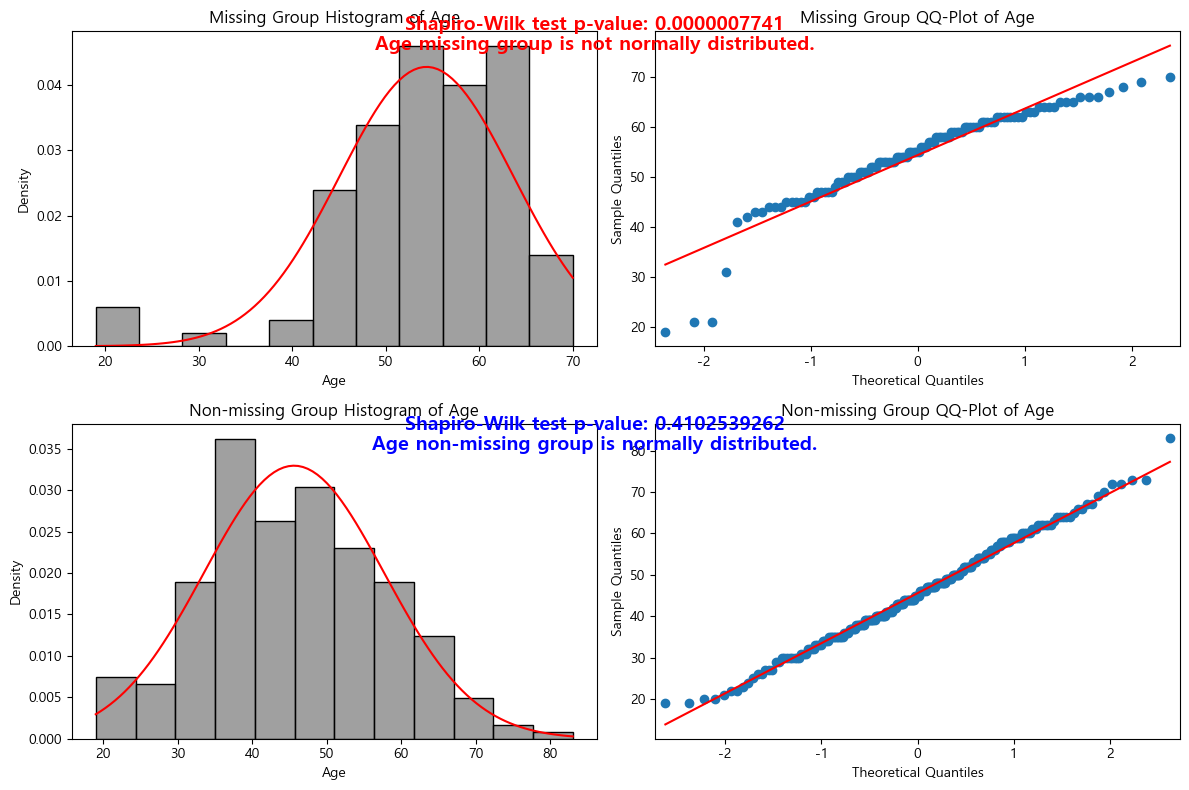

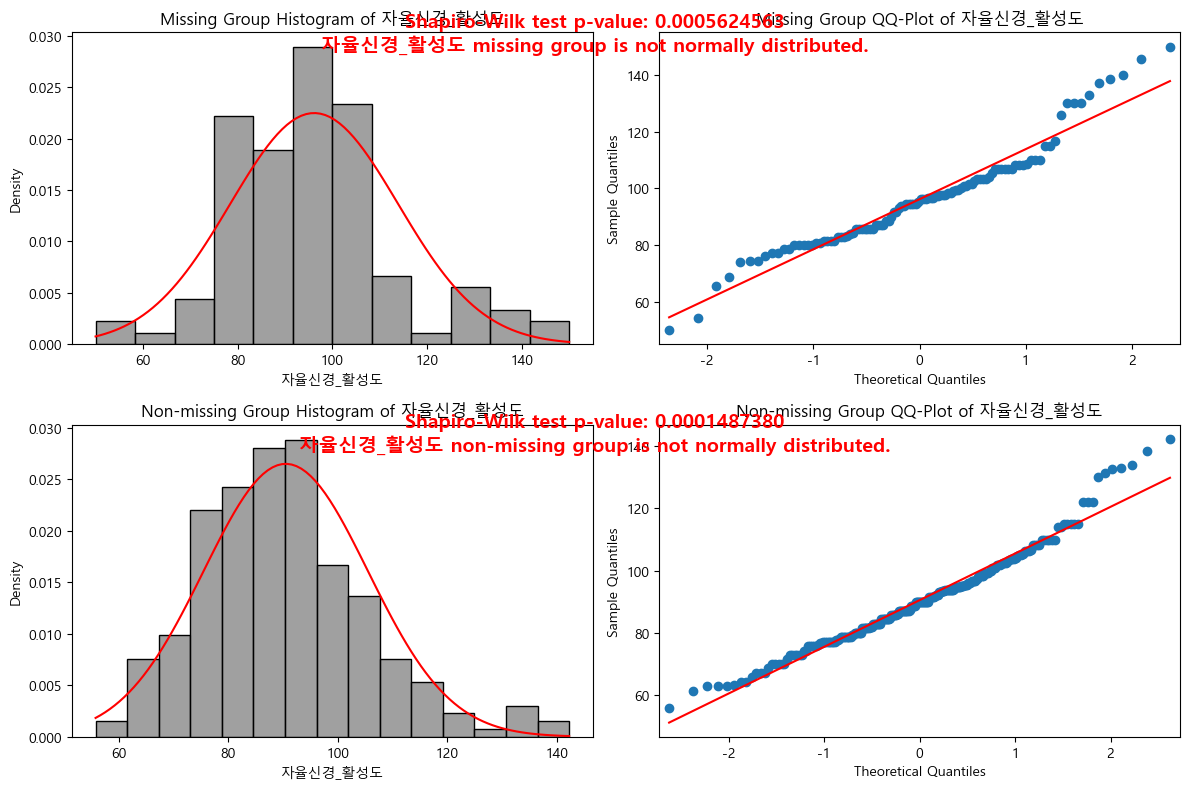

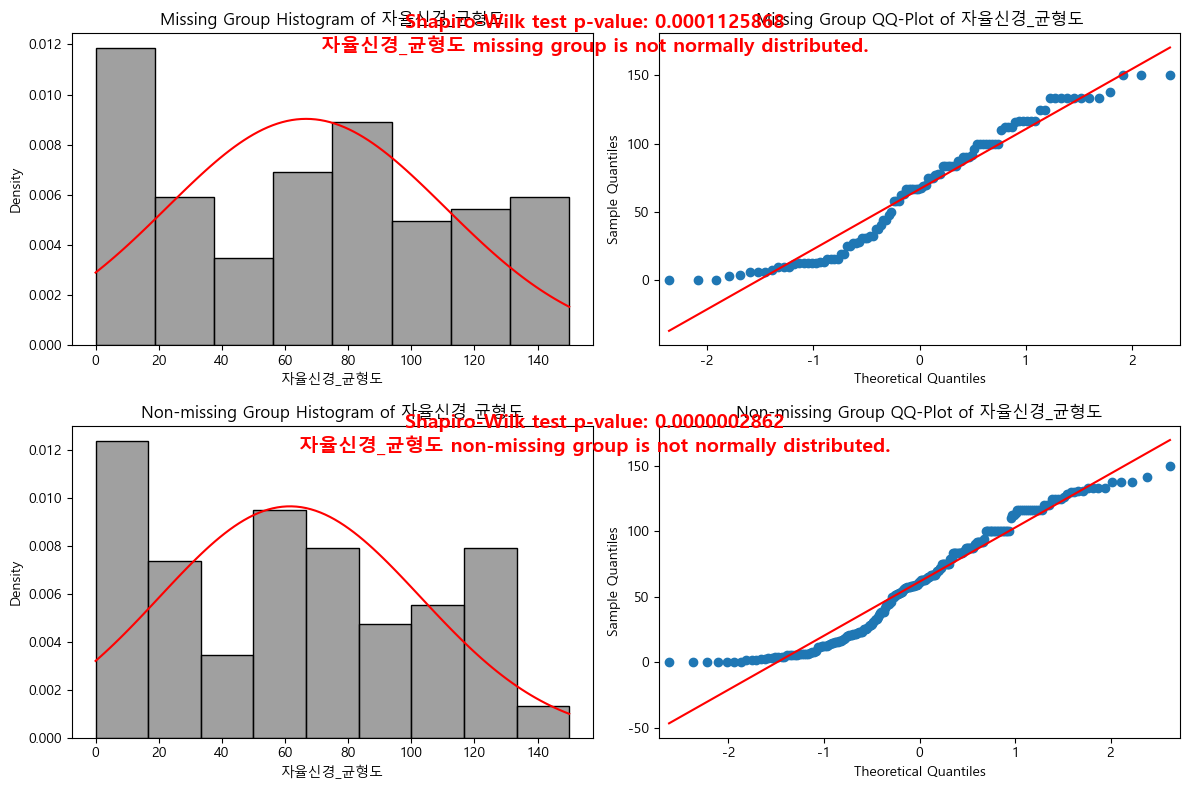

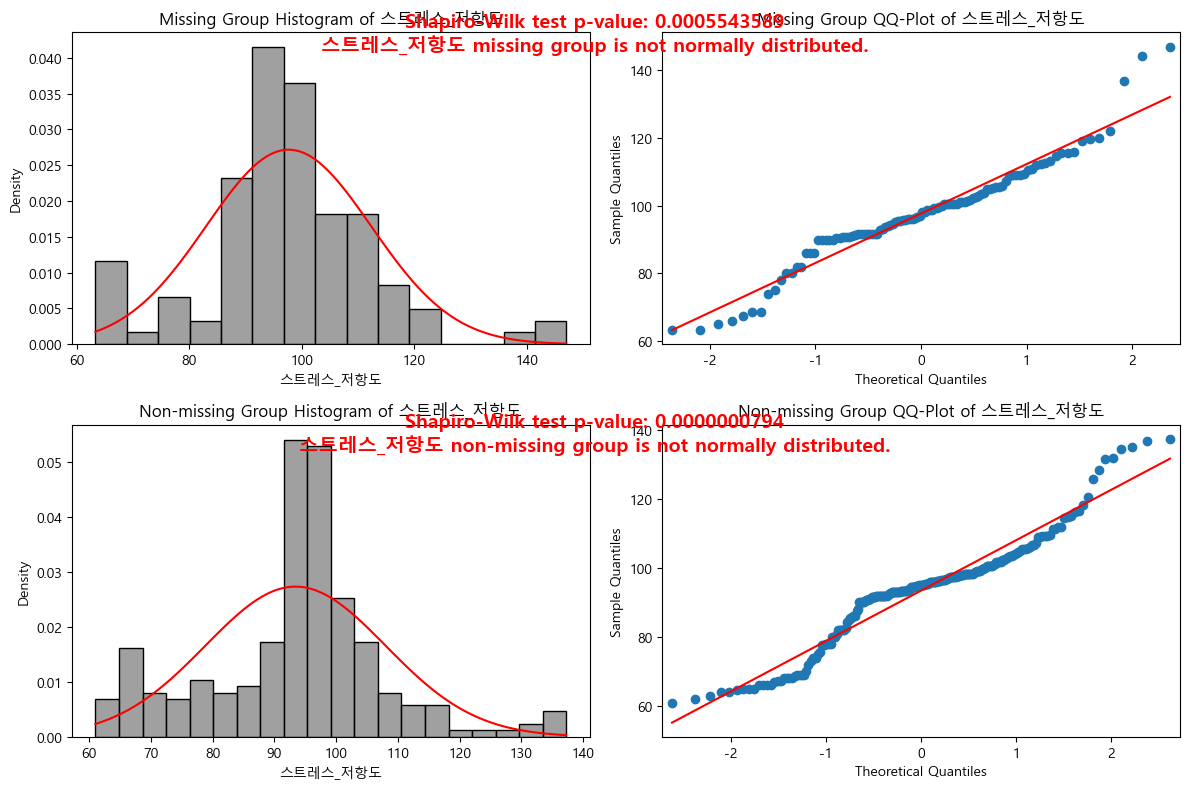

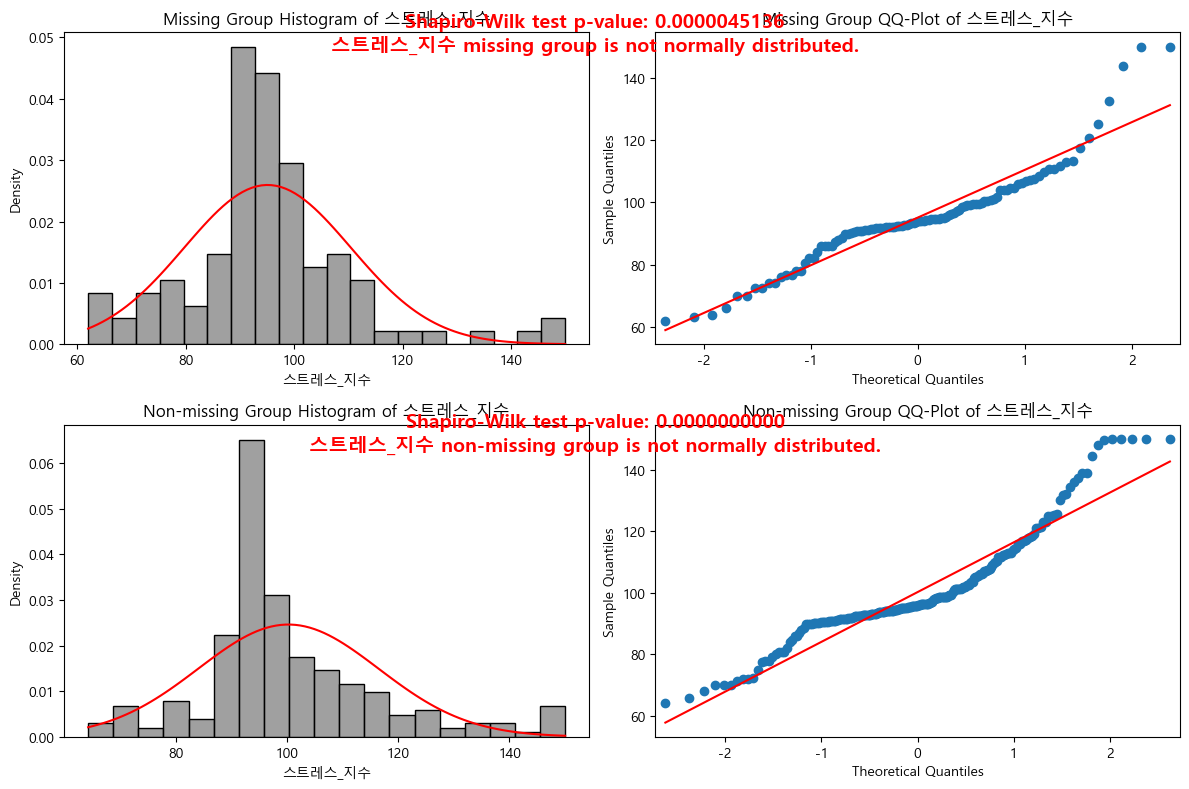

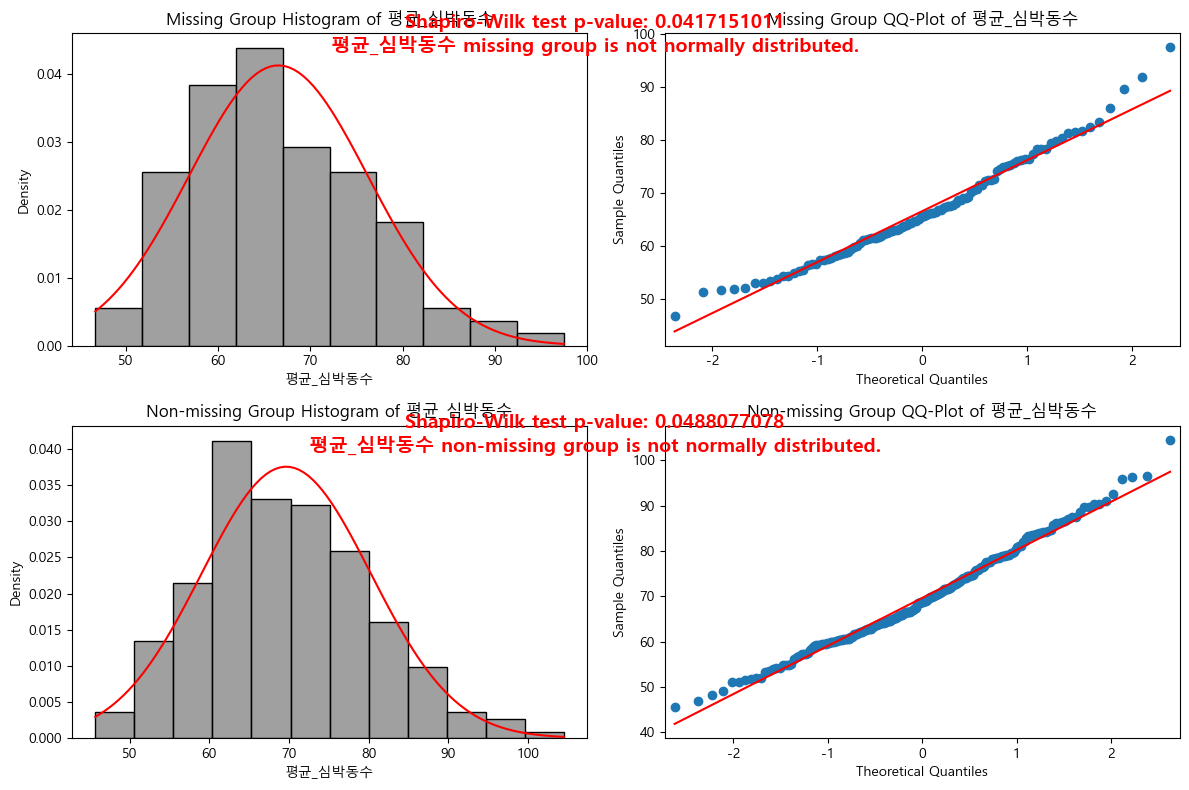

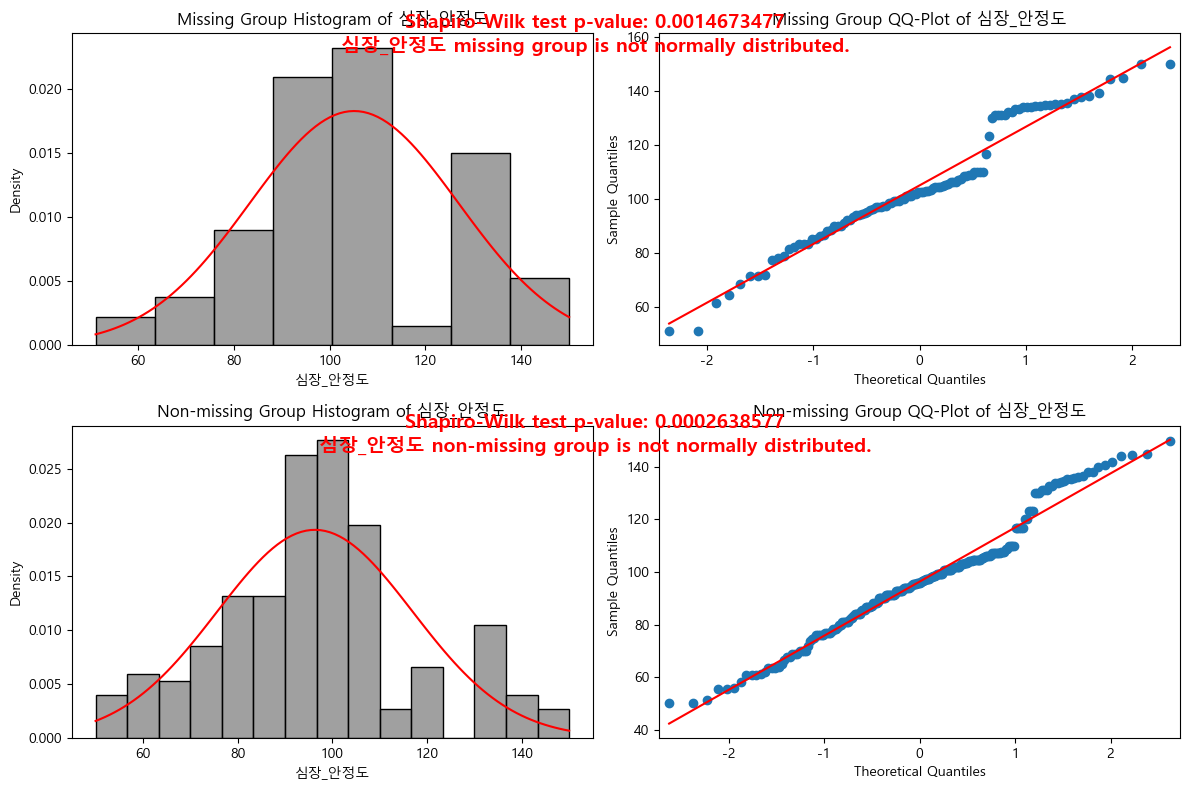

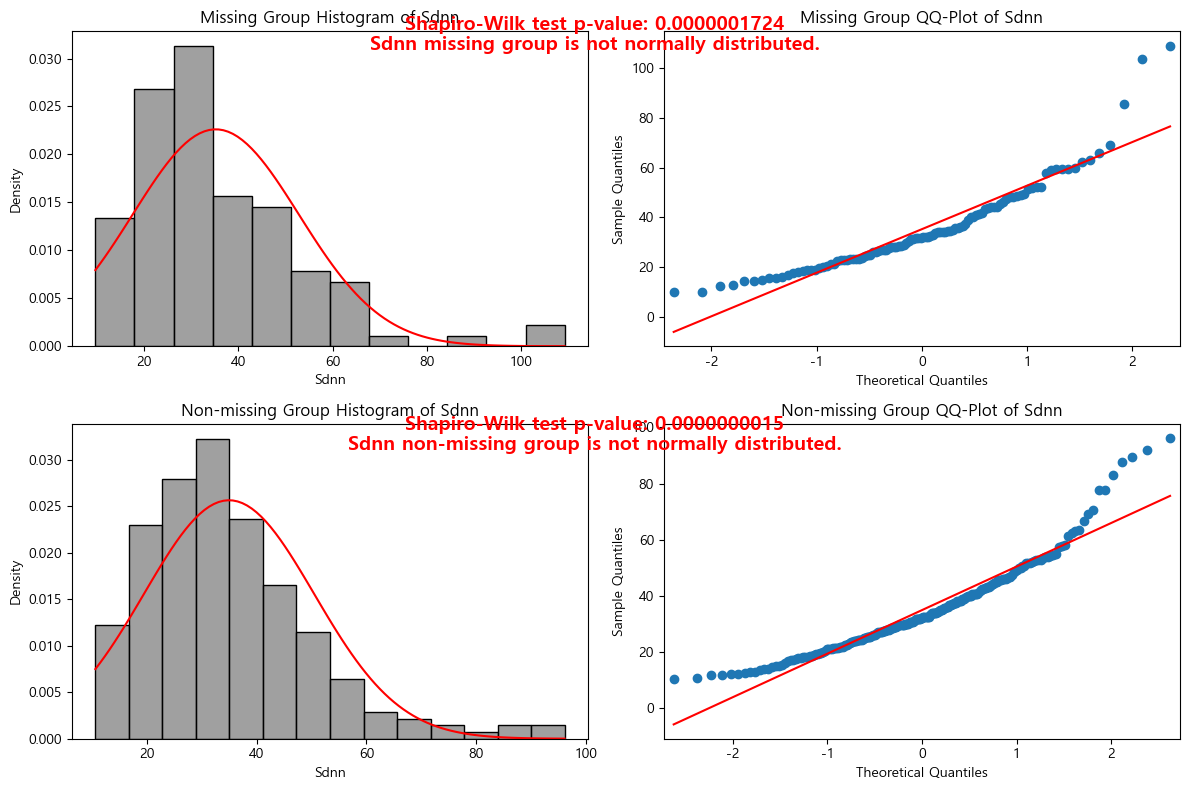

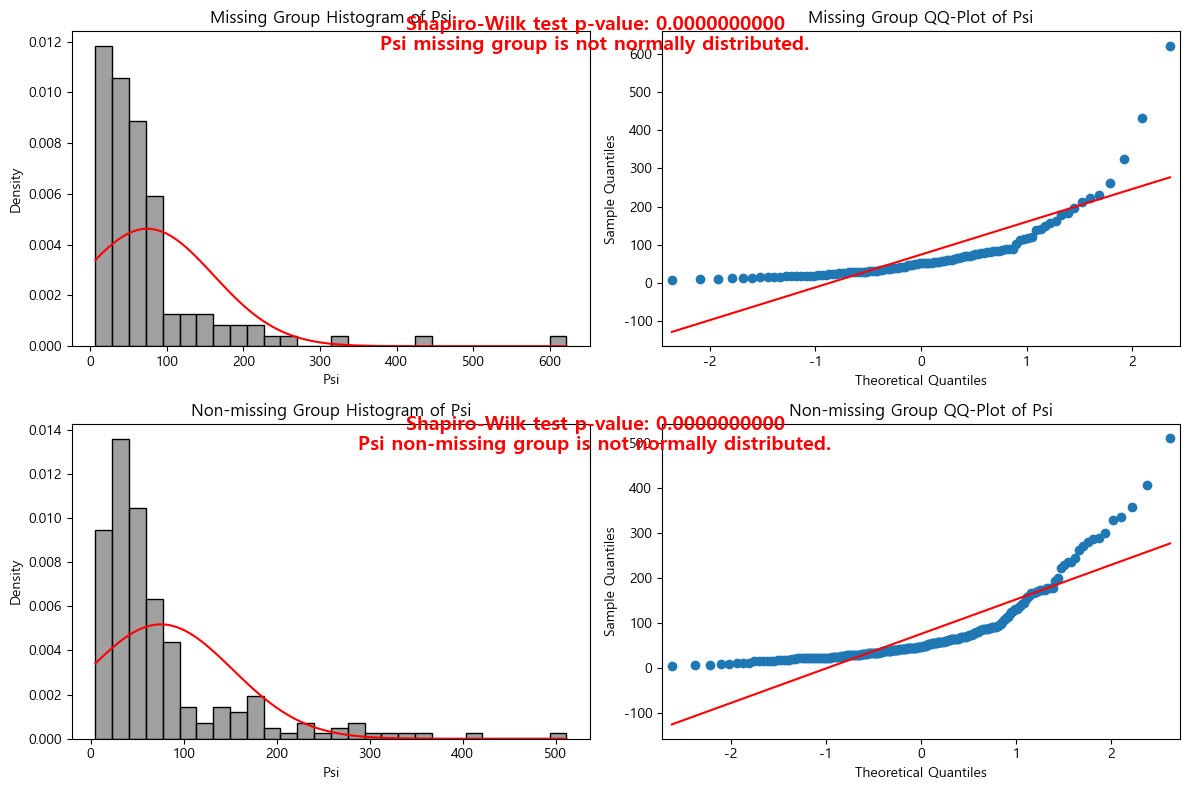

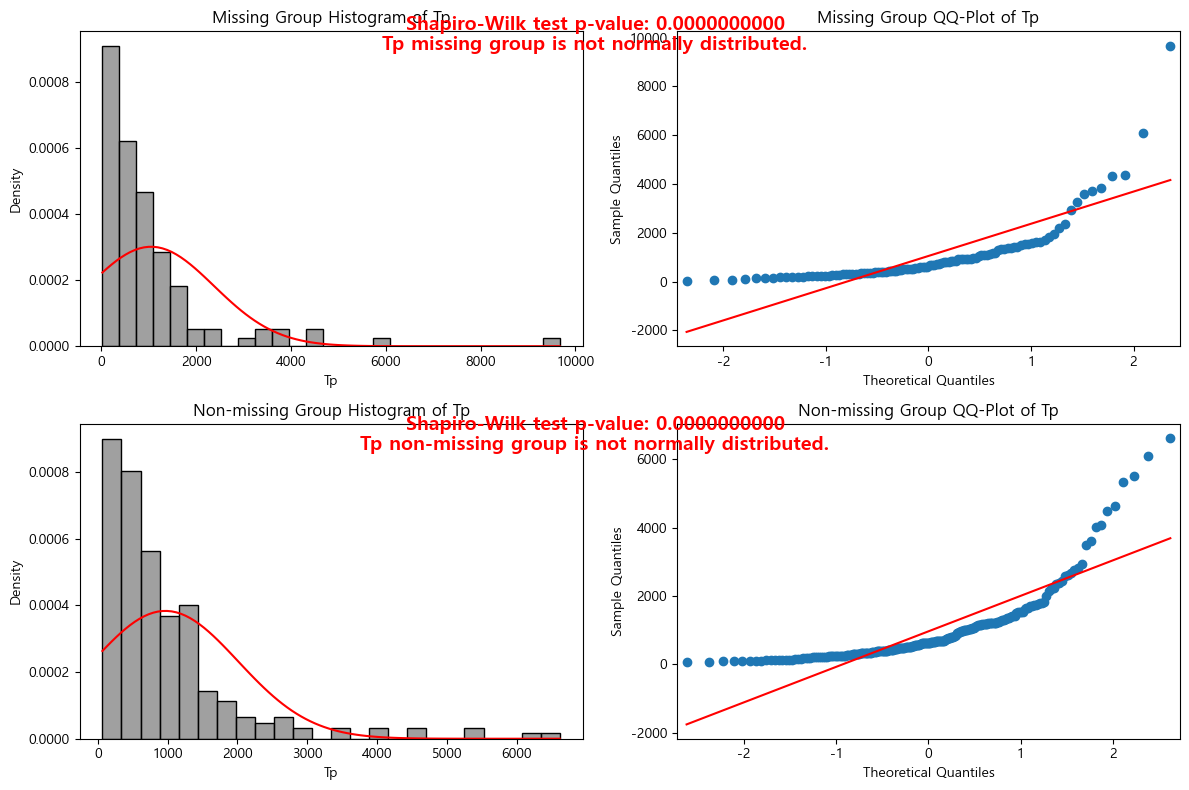

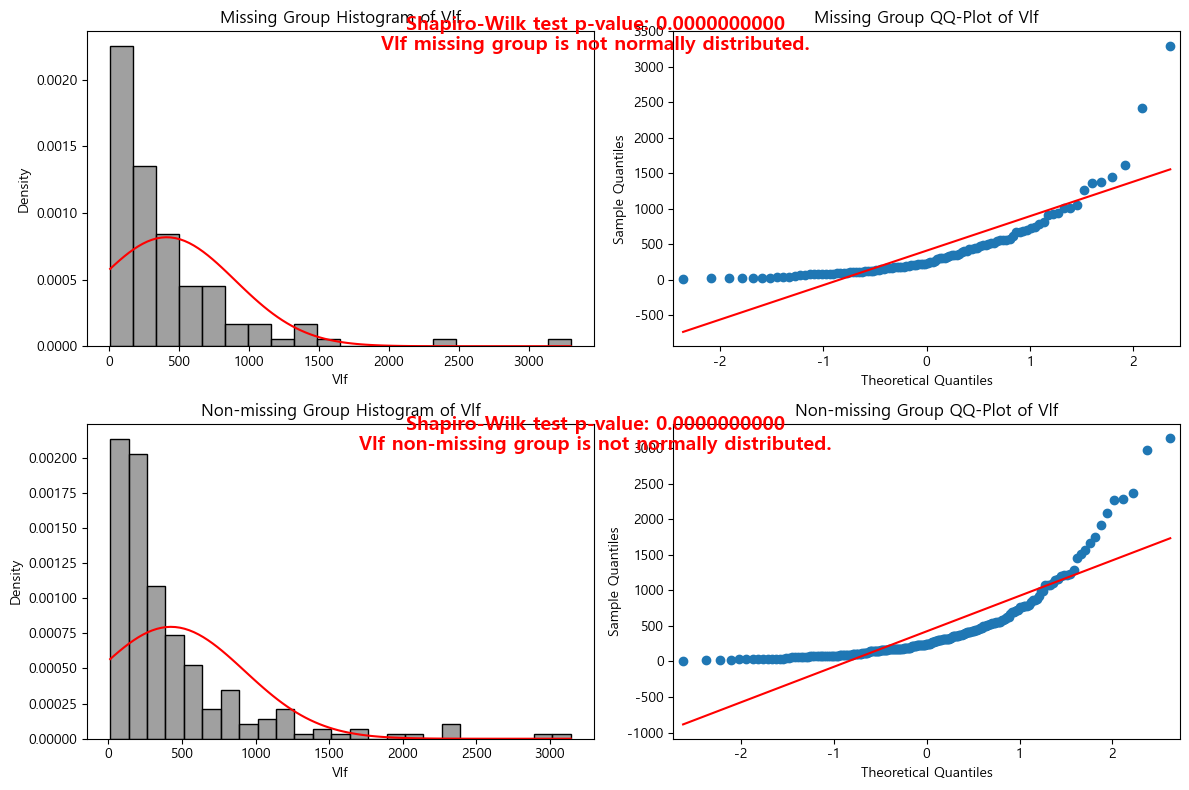

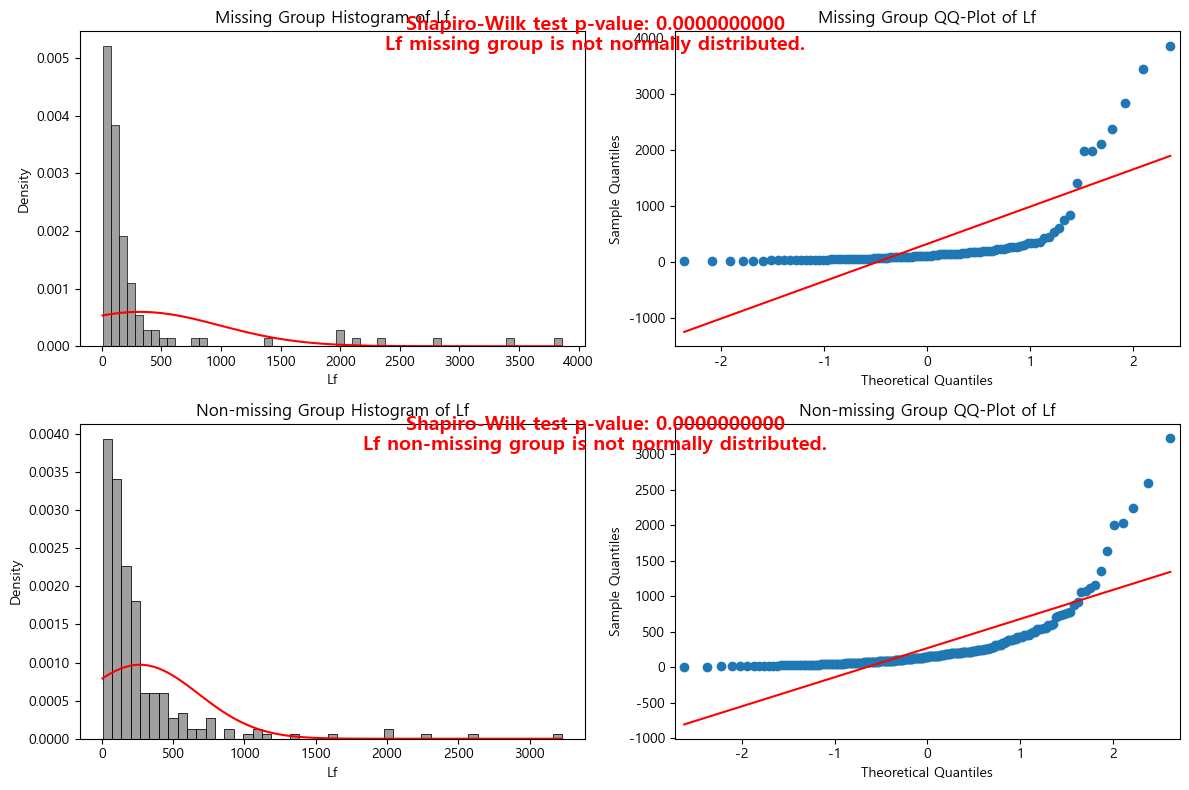

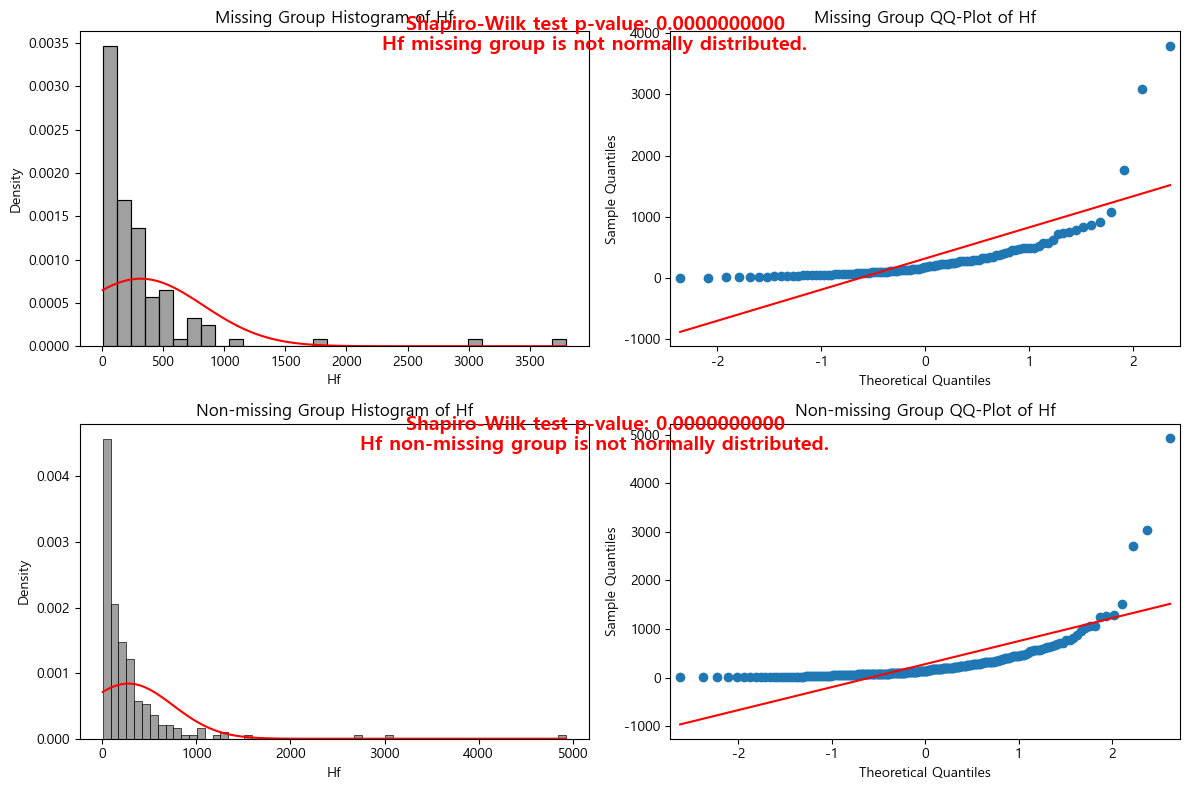

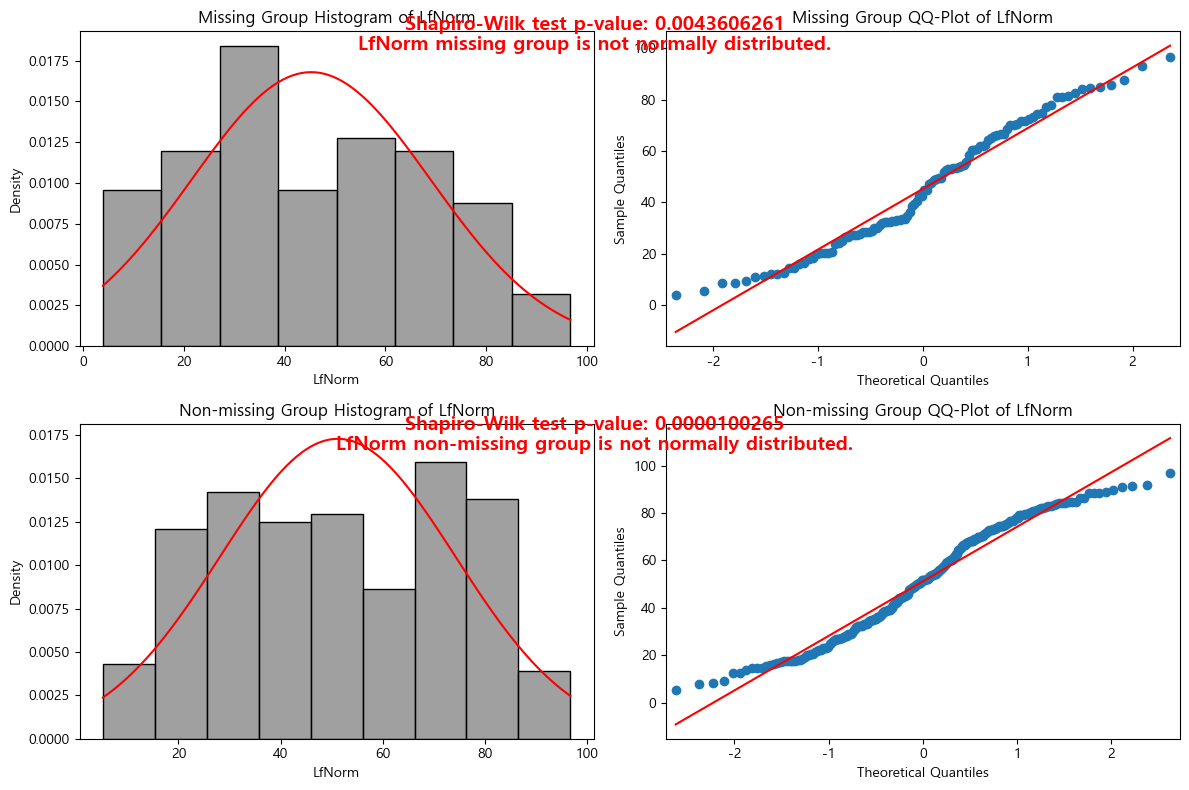

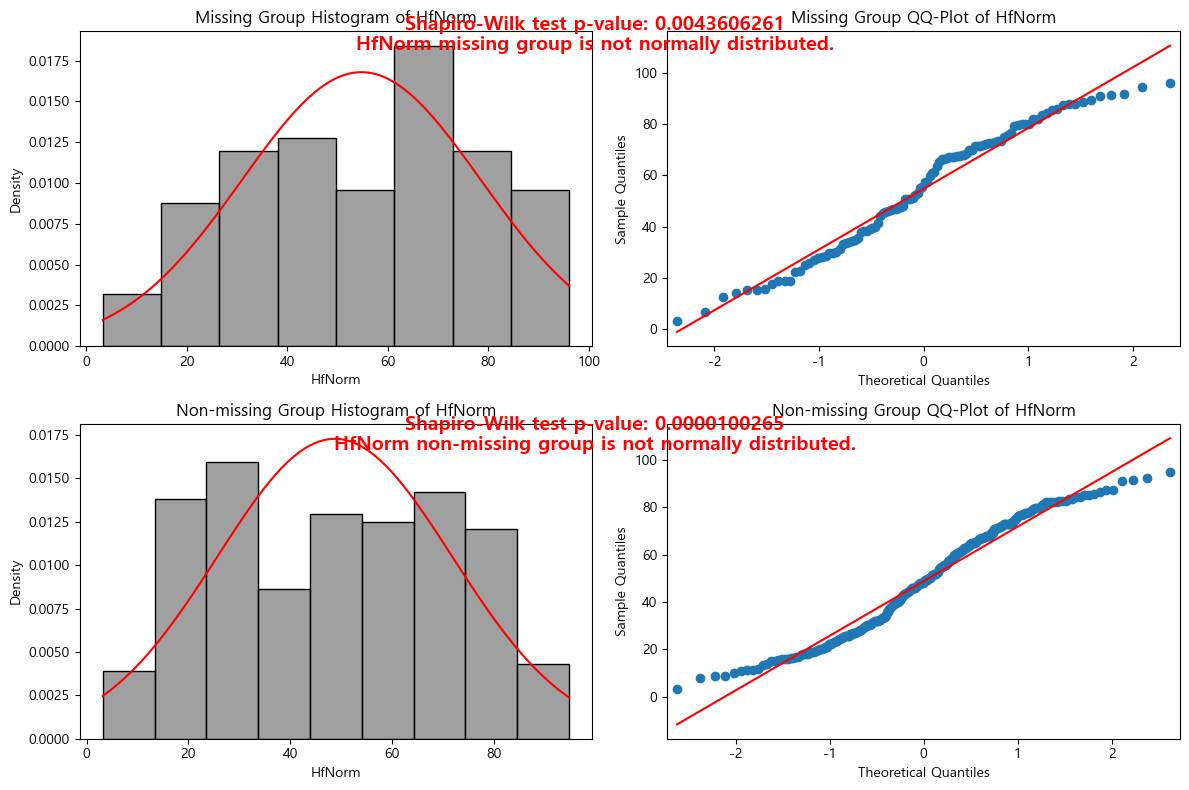

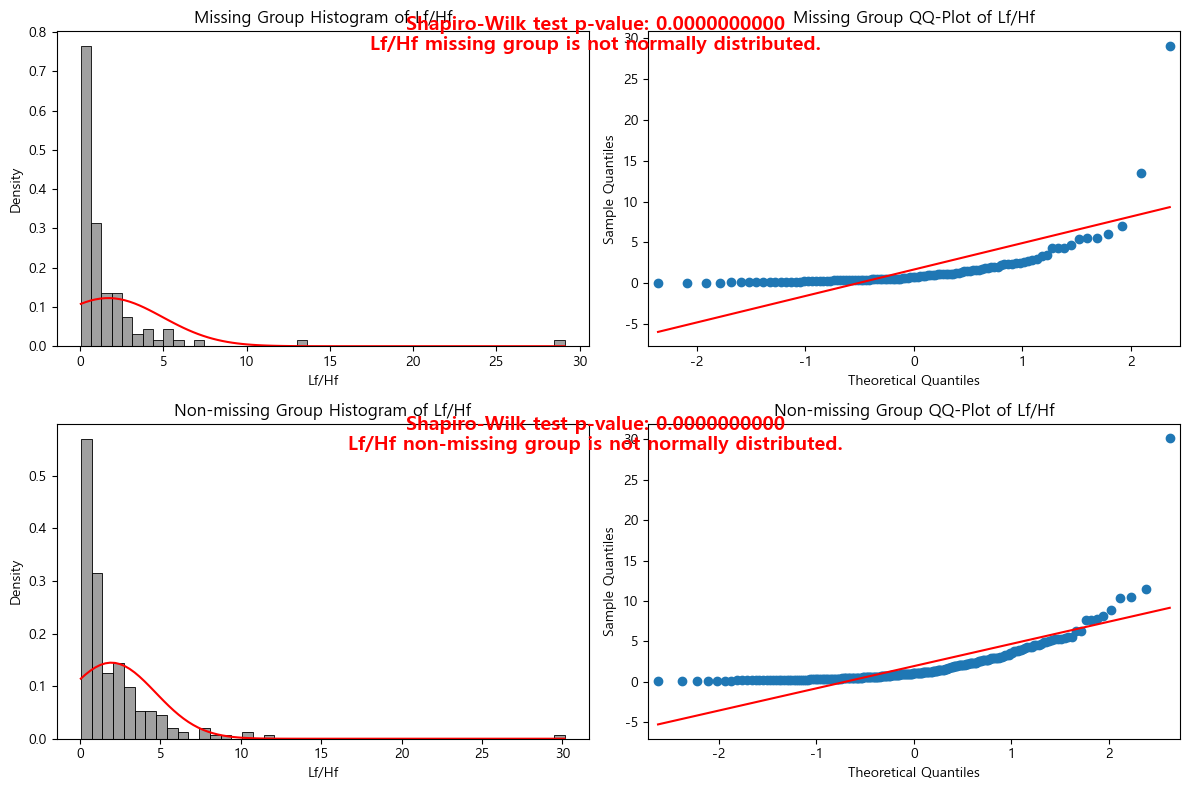

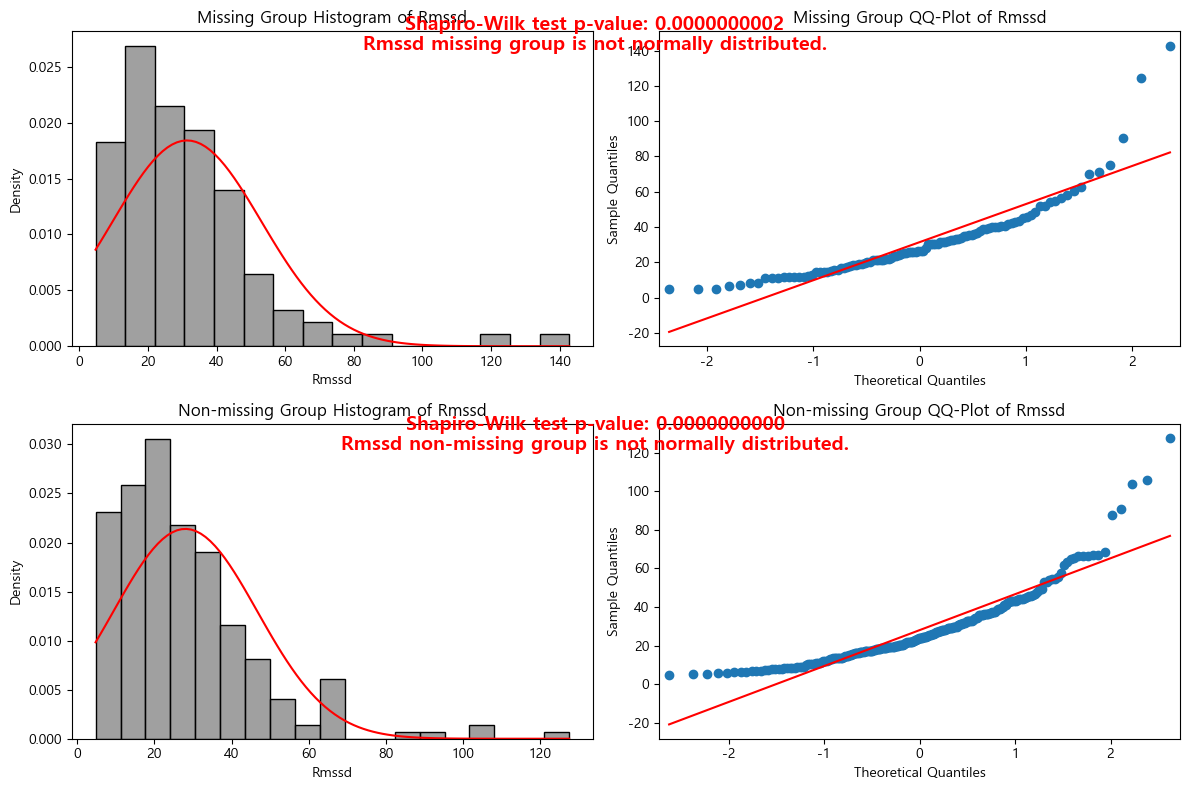

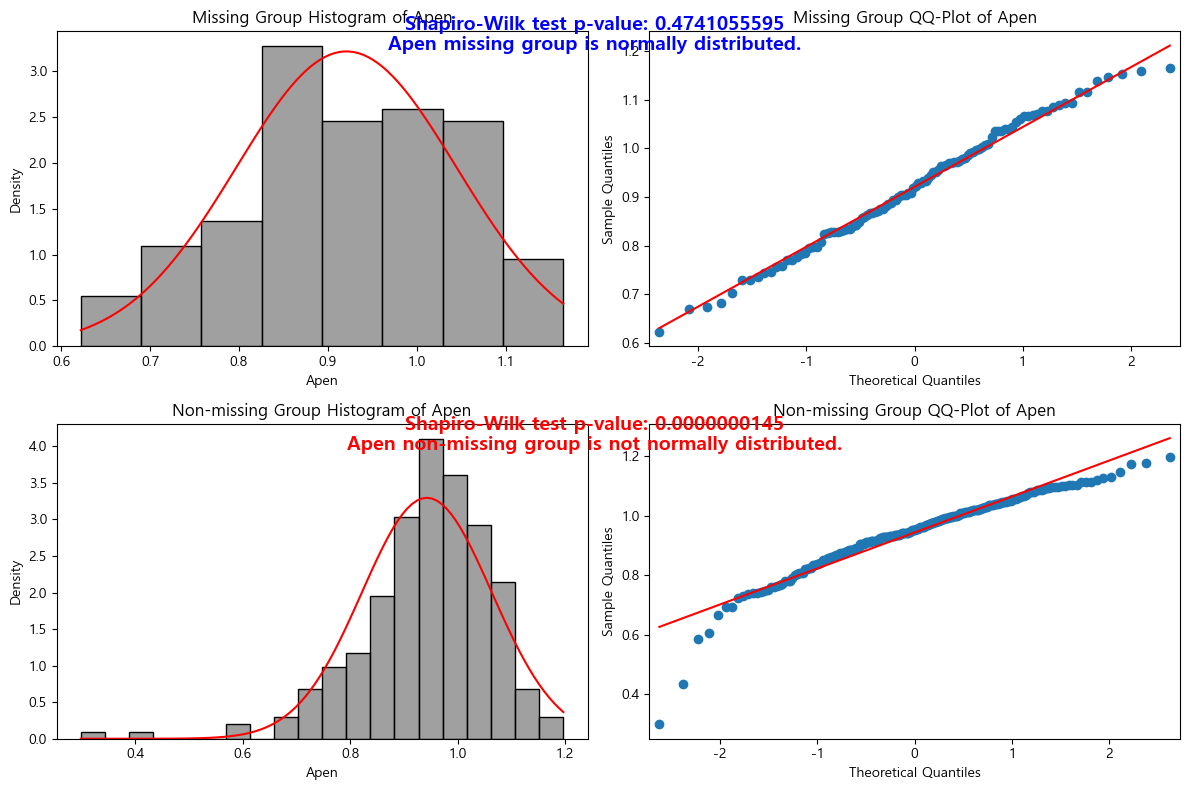

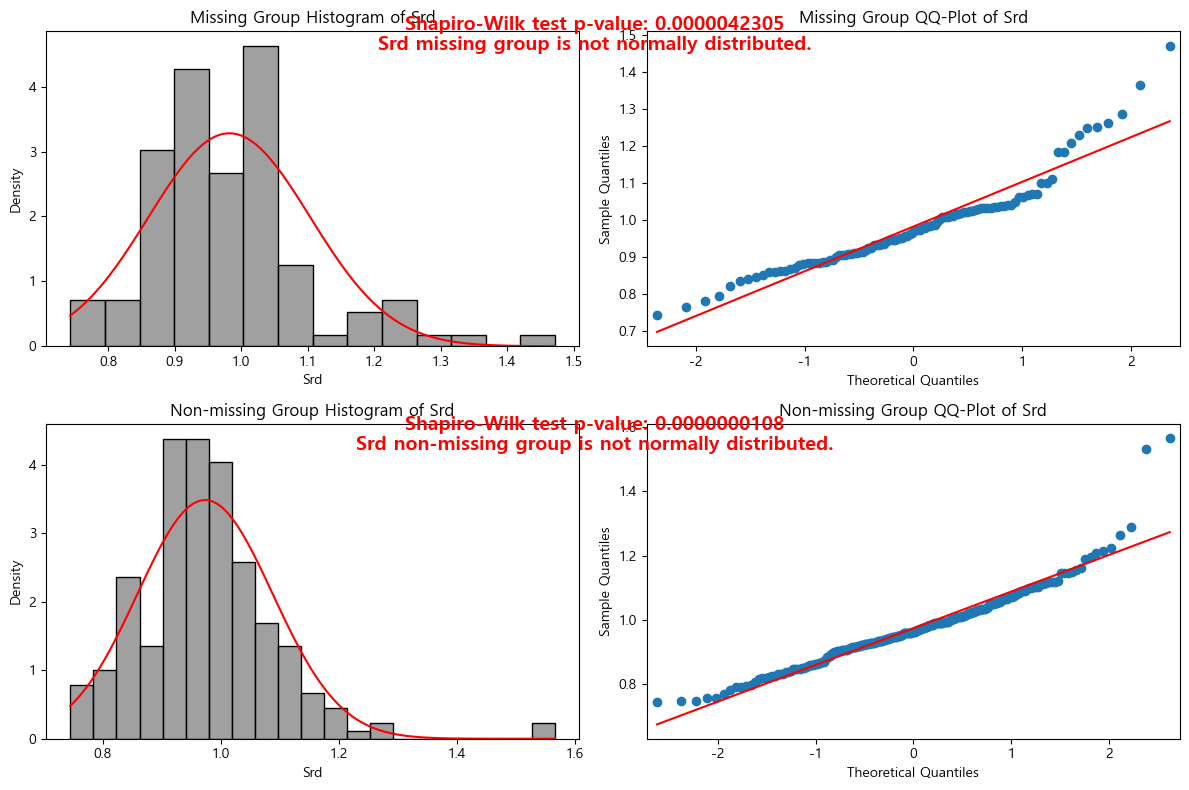

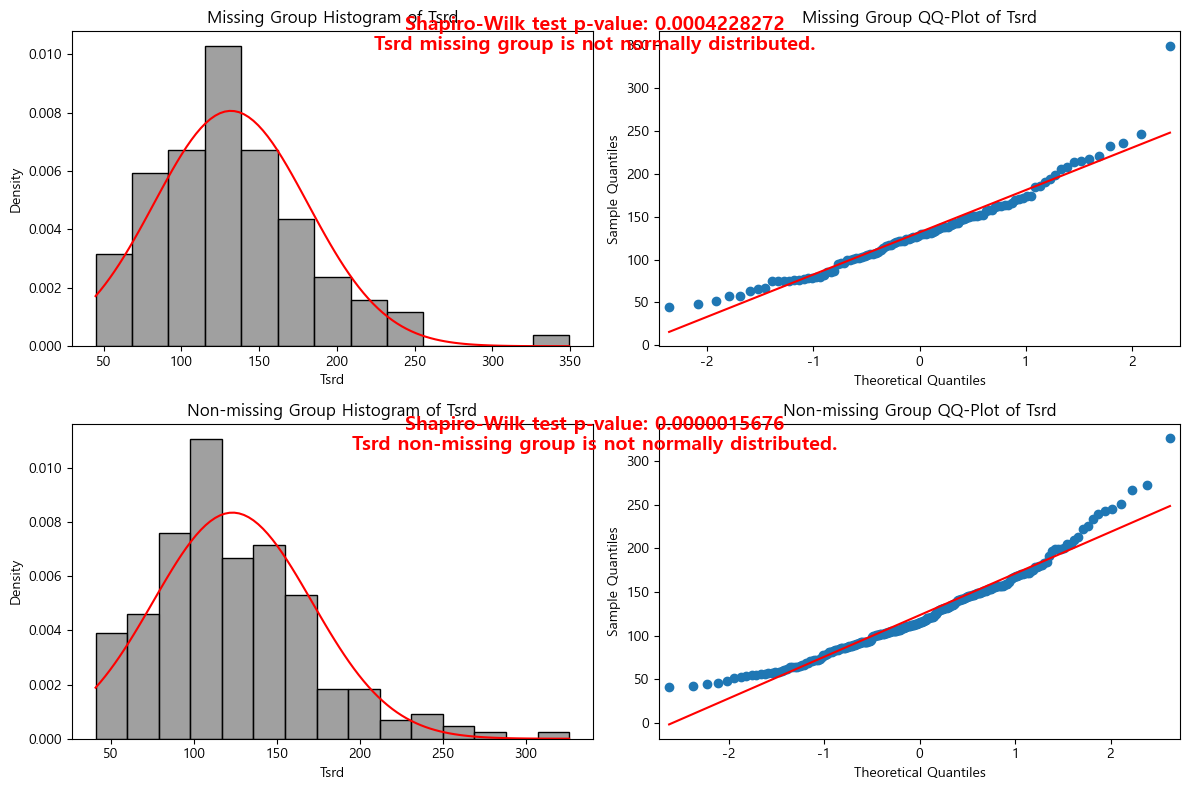

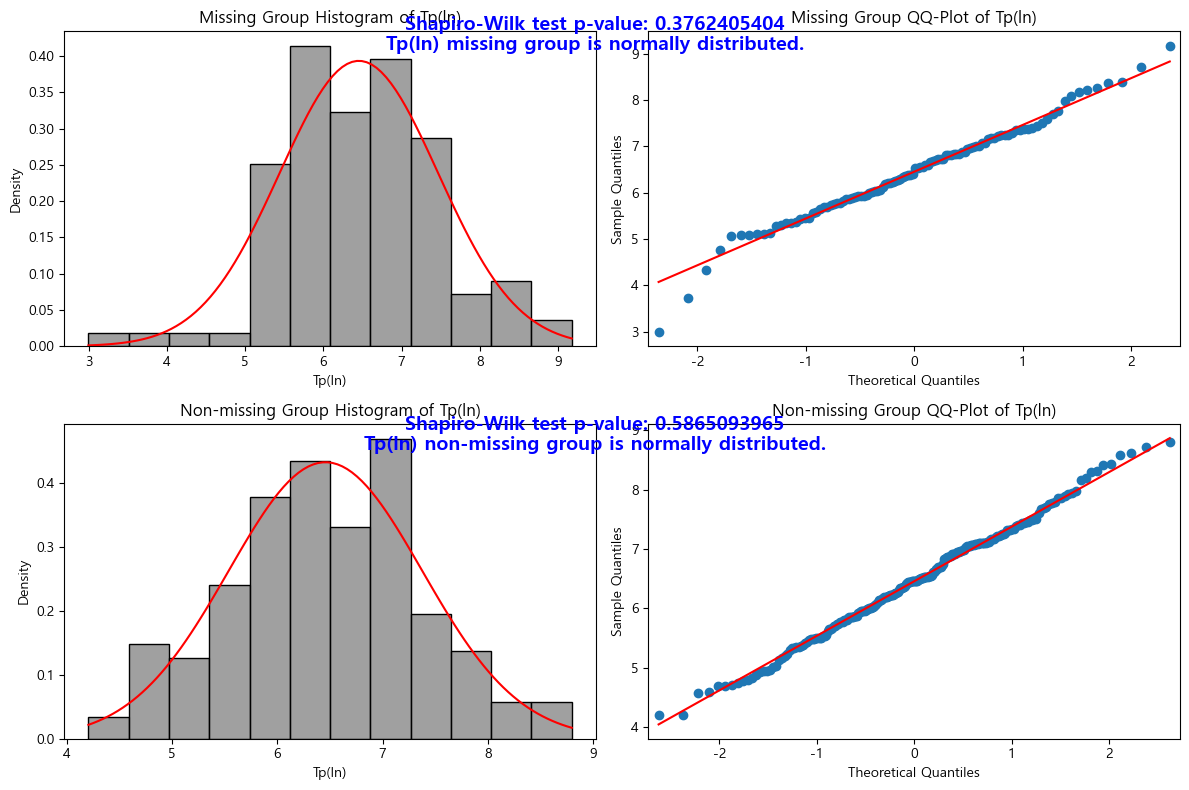

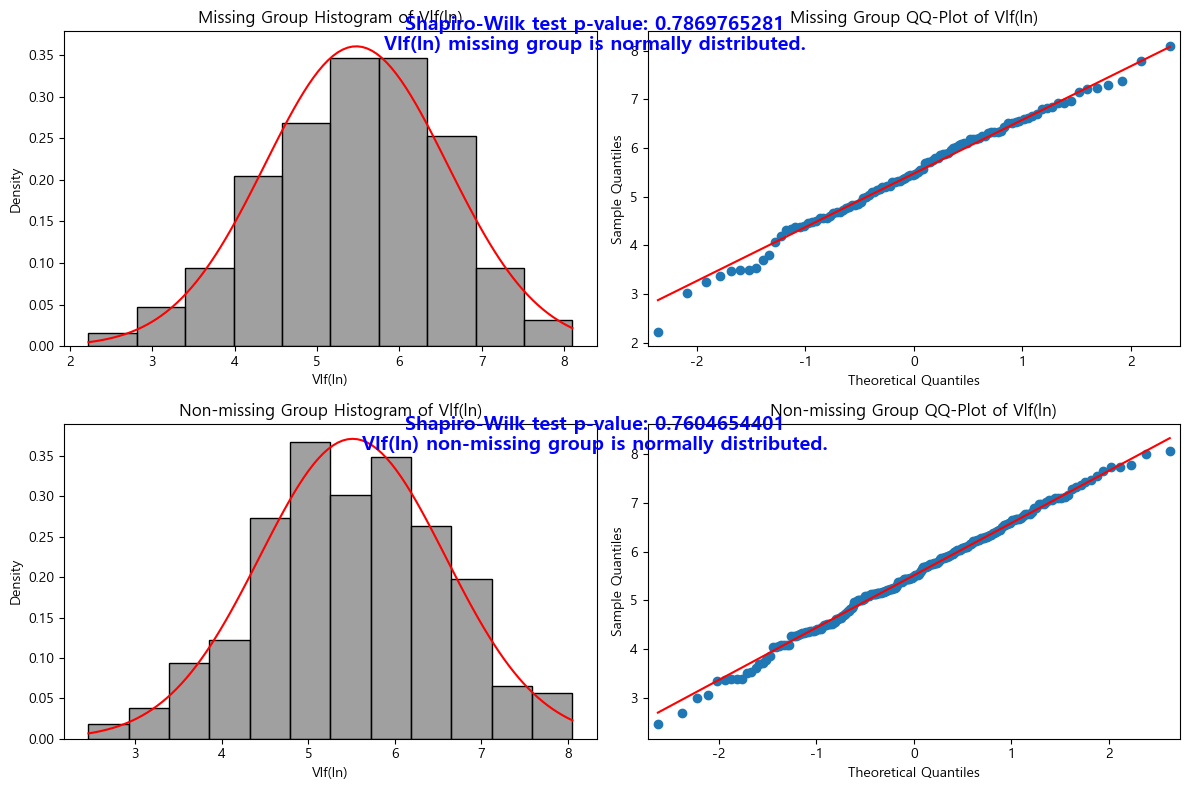

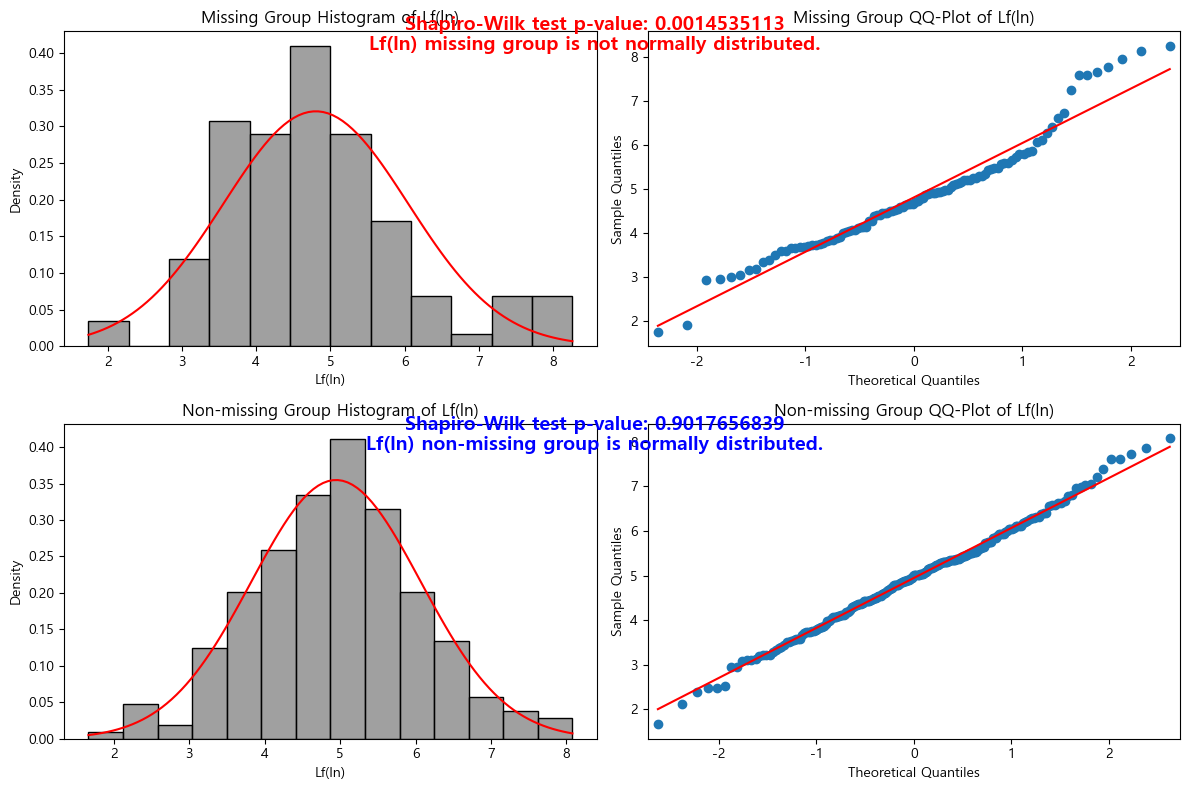

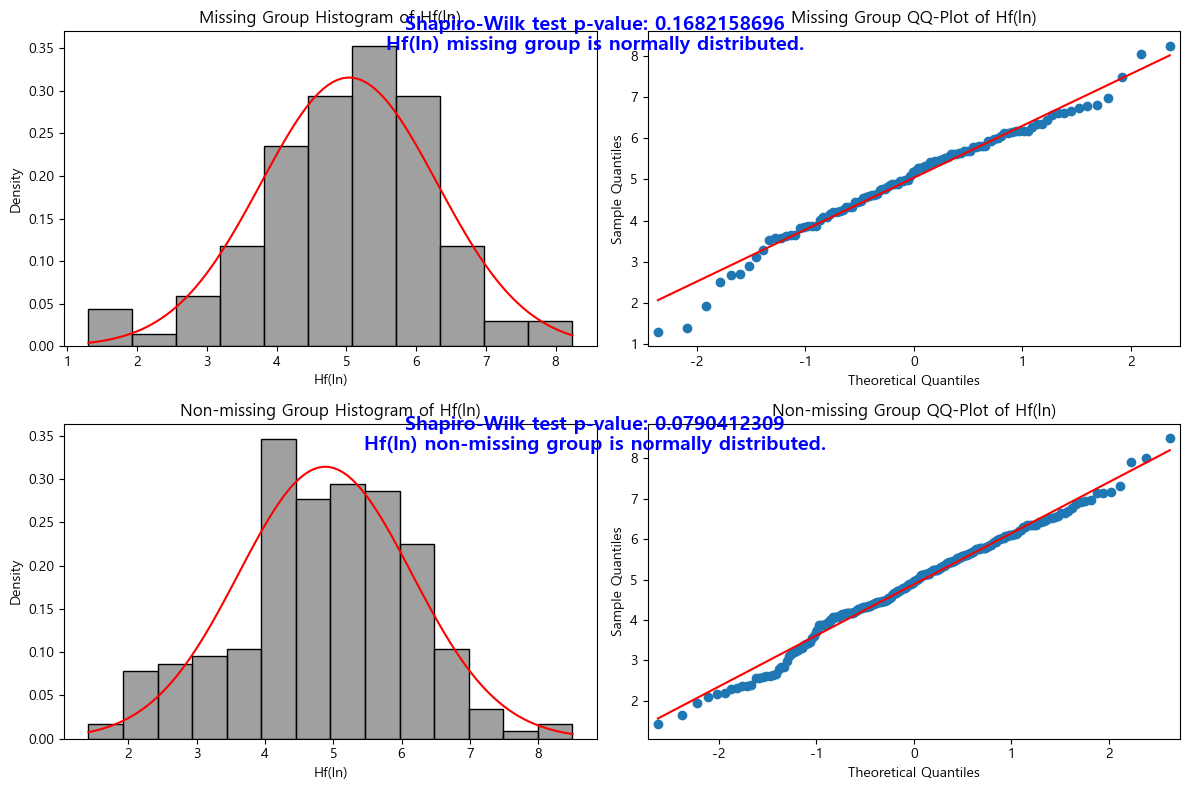

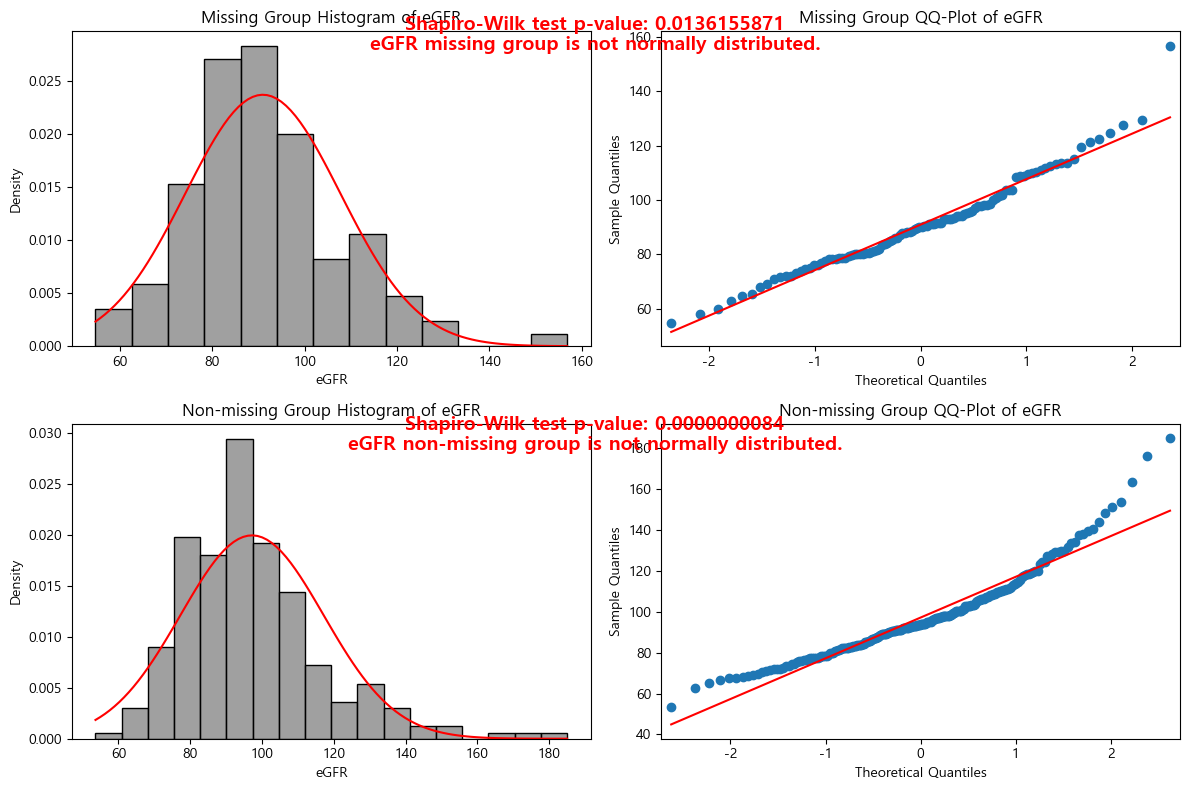

c:\anaconda3\envs\myenv\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


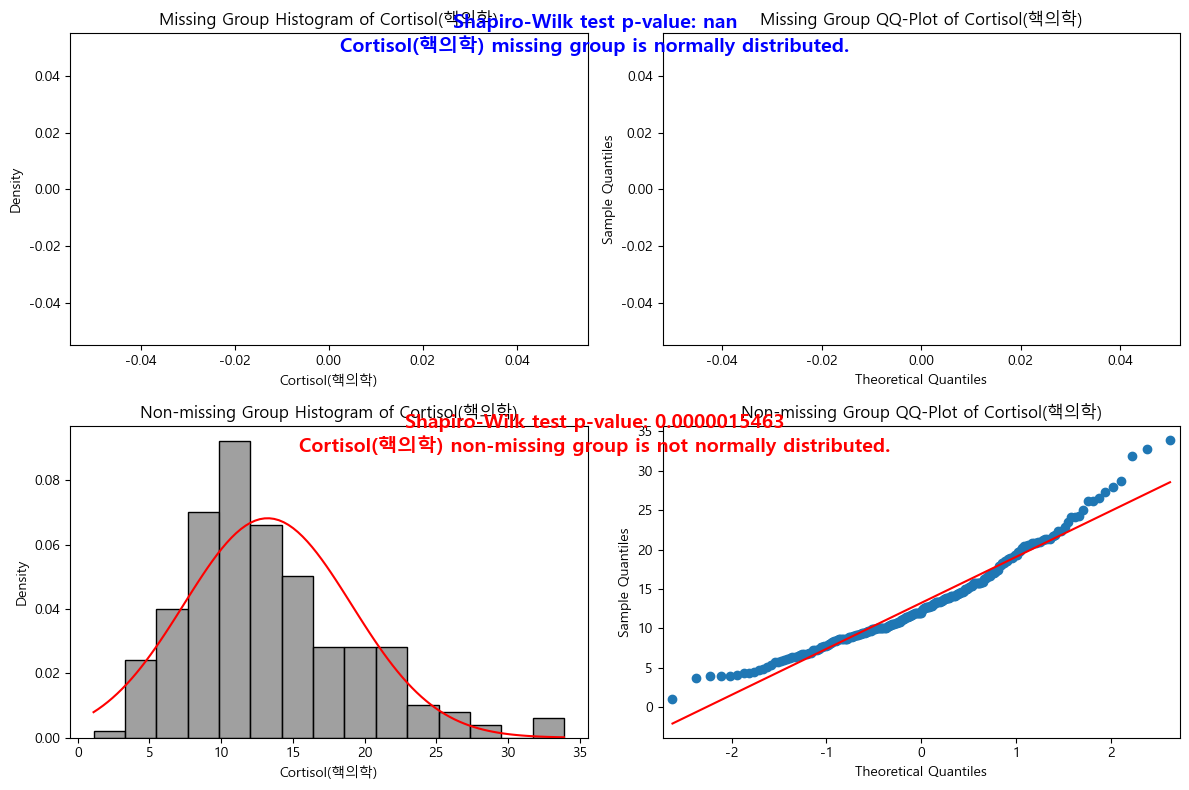

In [11]:
# Shapiro는 샘플 사이즈가 수백개 정도일때 정확한 결과를 보여주지만 샘플 사이즈가 수천개 이상이면 정확한 결과를 보여주지 않는다.
# 데이터가 수천~수만 건 이상이라면, Shapiro 검정이 아주 작은 차이에도 p-value가 극단적으로 작아질 수 있으니 QQ-plot 등을 추가로 확인하는 것이 좋음
# 여기서는 수백개 사이즈이지만, QQ-plot을 통해 추가 확인 진행
for i in num:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    sns.histplot(missing_group[i],kde=False, color='gray', stat='density', ax=axes[0,0])
    axes[0,0].set_title(f'Missing Group Histogram of {i}')
    axes[0,0].set_xlabel(i)
    axes[0,0].set_ylabel('Density')
    
    # 정규분포 곡선 추가
    x = np.linspace(missing_group[i].min(), missing_group[i].max(), 100)
    y = stats.norm.pdf(x, missing_group[i].mean(), missing_group[i].std())
    axes[0,0].plot(x, y, color='red')
    
    # 오른쪽 qq plot
    sm.qqplot(missing_group[i], line='s', ax=axes[0,1])
    axes[0,1].set_title(f'Missing Group QQ-Plot of {i}')
    
    # shapiro-wilk test 결과 출력
    stat, p_value = shapiro(missing_group[i])
    if p_value < 0.05:
        fig.text(0.5, 0.95, f"Shapiro-Wilk test p-value: {p_value:.10f}\n{i} missing group is not normally distributed.", ha='center', va='center', color = 'r',fontsize=14, fontweight = 'bold')
    else:
        fig.text(0.5, 0.95, f"Shapiro-Wilk test p-value: {p_value:.10f}\n{i} missing group is normally distributed.", ha='center', va='center', color='blue',fontsize=14, fontweight = 'bold')
    
    # non-missing group
    sns.histplot(non_missing_group[i], kde=False, color='gray', stat='density', ax=axes[1,0])
    axes[1,0].set_title(f'Non-missing Group Histogram of {i}')
    axes[1,0].set_xlabel(i)
    axes[1,0].set_ylabel('Density')
    
    # 정규분포 곡선 추가
    x = np.linspace(non_missing_group[i].min(), non_missing_group[i].max(), 100)
    y = stats.norm.pdf(x, non_missing_group[i].mean(), non_missing_group[i].std())
    axes[1,0].plot(x, y, color='red')
    
    # 오른쪽 qq plot
    sm.qqplot(non_missing_group[i], line='s', ax=axes[1,1])
    axes[1,1].set_title(f'Non-missing Group QQ-Plot of {i}')
    
    # shapiro-wilk test 결과 출력
    stat, p_value = shapiro(non_missing_group[i])
    if p_value < 0.05:
        fig.text(0.5, 0.45, f"Shapiro-Wilk test p-value: {p_value:.10f}\n{i} non-missing group is not normally distributed.", ha='center', va='center', color='r',fontsize=14, fontweight = 'bold')
    else:
        fig.text(0.5, 0.45, f"Shapiro-Wilk test p-value: {p_value:.10f}\n{i} non-missing group is normally distributed.", ha='center', va='center', color='blue',fontsize=14, fontweight = 'bold')

    plt.tight_layout()
    plt.show()

In [12]:
# Shapiro-Wilk 검정 결과, qq plot 결과 모두 정규성을 띄지 않는 변수가 많음
# 따라서 t test 사용 불가능 -> 대신 mann-whitney test 사용
# t test 의 경우 정규성 + 등분산성 가정을 만족해야 하지만, mann-whitney test 는 이 가정을 만족하지 않아도 사용 가능
# mann-whitney test 는 두 집단의 분포가 동일하다는 가정을 하지 않음
# 비모수 검정이므로 정규성을 띄지 않는 데이터에도 적용 가능

# 이 검정은 두 집단 간 분포의 위치 차이(주로 중앙값 차이) 가 있는지를 확인하므로, 정규성에 민감하지 않다.
# 귀무가설 두 집단의 분포가 동일하며 특히 중앙값(일반적으로 위치, 중심 경향)이 같다 
# 대립가설 두 집단의 분포가 다르다. 중앙값이 다르다.
# p-value가 0.05보다 작으면 귀무가설 기각 -> 두 집단의 분포가 다르다. 중앙값이 다르다.
# t-test 는 연속형 변수에 대해 정규성 +등분선성을 가정하지만
# mann-whitney test 는 순위에 기반하기 때문에 정규성 가정이 크게 어긋나도(분포가 skew 되어도) 사용 가능
for i in num:
    stat, p = mannwhitneyu(missing_group[i], non_missing_group[i], alternative='two-sided')
    if p < 0.05:
        # p-value가 0.05보다 작으면 귀무가설 기각 -> 두 집단의 분포가 다르다. 중앙값이 다르다.
        print(f"{BRIGHT_YELLOW}{i} Mann-Whitney test p-value: {p:.10f}{BRIGHT_END}")
        print(f"{i} missing group and non-missing group have different distributions.")
    else:
        # p-value가 0.05보다 크면 귀무가설 채택 -> 두 집단의 분포가 같다. 중앙값이 같다.
        # -> 통계적으로 유의미한 차이가 있다고 보기 어렵다
        print(f"{BRIGHT_BLACK}{i} Mann-Whitney test p-value: {p:.10f}")
        print(f"{i} missing group and non-missing group have similar distributions.{BRIGHT_END}")

# MCAR 의 경우 관측된 변수들에서 결측 여부에 따라 두 그룹이 유의미하게 다르지 않아야 함        
# p-value가 0.05보다 작은 변수가 생각보다 꽤 있음 -> MCAR(무작위 결측)이 아닐 가능성이 높음
# 결측치가 무작위로 발생했다고 보기 어렵고, 오히려 특정 패턴이 있을 수 있음
# 결측치가 무작위로 발생햇다고 생각하고 결측치를 제거해버리면 편향된 결과가 나올 수 있음
# 단순히 결측치를 제거하기보다는 예측 모델을 통해 결측치를 대체하는 것이 더 나을 수 있음

Age Mann-Whitney test p-value: 0.0000000000
Age missing group and non-missing group have different distributions.
자율신경_활성도 Mann-Whitney test p-value: 0.0027880489
자율신경_활성도 missing group and non-missing group have different distributions.
자율신경_균형도 Mann-Whitney test p-value: 0.3062146227
자율신경_균형도 missing group and non-missing group have similar distributions.
스트레스_저항도 Mann-Whitney test p-value: 0.0155366950
스트레스_저항도 missing group and non-missing group have different distributions.
스트레스_지수 Mann-Whitney test p-value: 0.0044542130
스트레스_지수 missing group and non-missing group have different distributions.
평균_심박동수 Mann-Whitney test p-value: 0.0105705649
평균_심박동수 missing group and non-missing group have different distributions.
심장_안정도 Mann-Whitney test p-value: 0.0004363191
심장_안정도 missing group and non-missing group have different distributions.
Sdnn Mann-Whitney test p-value: 0.7964509186
Sdnn missing group and non-missing group have similar distributions.
Psi Mann-Whitney test p-value: 0.72322

1️⃣ 완전무작위 결측 (MCAR: Missing Completely At Random)   
- 결측치가 특정한 이유 없이 무작위로 발생하는 경우
예: 한 지역의 주민 데이터를 수집했는데, 중간 이름(Middle Name)이 50% 비어 있음    
→ 특정한 패턴이 없는 결측치   

✔ 처리 방법   

- 리스트 삭제(Listwise Deletion): 결측값이 있는 행을 전체 삭제 (결측 데이터가 2% 이하일 때 효과적)   
- 쌍별 삭제(Pairwise Deletion): 상관관계를 계산할 때, 결측값이 있는 변수만 제외하고 나머지는 유지 (데이터 손실을 최소화)
- 평균, 중앙값, 최빈값 대체 (Mean, Median, Mode Imputation)   

2️⃣ 무작위 결측 (MAR: Missing At Random)   
- 결측치가 다른 변수와 관계가 있는 경우   
예: 주민 데이터에서 45세 이상의 남성의 급여(salary) 값만 결측 → 특정 변수(성별, 연령)에 따라 결측이 발생 

✔ 처리 방법

- 평균, 중앙값, 최빈값 대체
- 다중 대체(Multiple Imputation) → 여러 개의 모델을 활용하여 결측값을 예측 및 보정   

3️⃣ 무작위가 아닌 결측 (MNAR: Missing Not At Random)   
- 결측값 자체가 특정한 패턴을 따르는 경우   
예: 연봉이 1억 이상인 사람들만 급여 정보가 결측 → 급여 데이터가 일정 기준 이상일 때 숨겨짐   

✔ 처리 방법

- 데이터 수집을 추가적으로 수행
- 결측값을 예측하는 모델을 활용하여 대체


#### 결측 메거니즘 평가
- 결측 데이터가 무작위(MCAR)로 발생했는지 판단하기 위해 Little's MCAR test를 사용
- Little's MCAR test가 유의하지 않으면 결측이 MCAR일 가능성이 높지만 유의하면 MCAR 가정을 기각하게 됨. 즉, 결측이 MCAR이 아닌 MAR 또는 MNAR일 가능성이 높음

➡️ 귀무가설 : 모든 변수의 결측치가 완전히 무작위로 발생한다. 즉, 결측값이 있는 관측치와 없는 관측치 간에 아무런 체계적인 차이가 없다. (MCAR)   
➡️ 대립가설 : 적어도 한 변수에서 결측치가 무작위로 발생하지 않는다. (MAR 또는 MNAR)

- 테스트는 각 변수의 결측 패턴과 전체 데이터의 분산-공분산 구조를 이용해, 관측된 결측 패턴이 우연히 나타날 확률을 계산함.   
- p‑value가 0.05보다 작으면 귀무가설을 기각하여, 결측치가 무작위로 발생하지 않는다고 결론 내림.

In [13]:
mcar_test = MCARTest()

# 테스트 실행: 기본적으로 모든 변수의 결측 패턴을 고려
p_value = mcar_test.little_mcar_test(df)
print(f"p-value: {p_value:.20f}")

# p-value가 0.05보다 크면 귀무가설 기각 x -> 결측치가 완전 무작위(MCAR)일 가능성이 높음
# 즉, 코르티솔 결측값이 다른 변수들과 체계적인 관련 없이 랜덤하게 발생햇다는 것 을 의미
# 이 경우 결측치를 삭제해도 편향이 발생할 위험 낮음

# p-value가 0.05보다 작으면 귀무가설 기각 -> 결측치가 완전 무작위(MCAR)가 아닐 가능성이 높음
# 즉, 코르티솔 결측값이 다른 변수들과 체계적인 관련이 있을 수 있음. 무작위 결측이 아닌 MAR 또는 MNAR일 가능성이 높음
# 이 경우 결측치를 삭제하면 편향된 결과가 나올 수 있음 -> 예측 기반 imputation 사용 고려

# little's MCAR test 결과 p-value가 0.05보다 작으므로 귀무가설 기각
# 결측치가 완전 무작위(MCAR)가 아닐 가능성이 높음

p-value: 0.00000000000000000000


- MNAR은 아니라고 판단이 됐으므로, 해당 결측이 MAR인지 MNAR인지 판단

In [ ]:
'''df.columns : ['Age', 'Sex', '자율신경_활성도', '자율신경_균형도', '스트레스_저항도', '스트레스_지수', '평균_심박동수',
       '심장_안정도', 'Sdnn', 'Psi', 'Tp', 'Vlf', 'Lf', 'Hf', 'LfNorm', 'HfNorm',
       'Lf/Hf', 'Rmssd', 'Apen', 'Srd', 'Tsrd', 'Tp(ln)', 'Vlf(ln)', 'Lf(ln)',
       'Hf(ln)', 'FSS', 'eGFR', 'Cortisol(핵의학)', 'Cortisol_missing']'''
features = ['Age', 'Sex', '자율신경_활성도', '자율신경_균형도', '스트레스_저항도', '스트레스_지수', '평균_심박동수',
       '심장_안정도', 'Sdnn', 'Psi', 'Tp', 'Vlf', 'Lf', 'Hf', 'LfNorm', 'HfNorm',
       'Lf/Hf', 'Rmssd', 'Apen', 'Srd', 'Tsrd', 'Tp(ln)', 'Vlf(ln)', 'Lf(ln)',
       'Hf(ln)', 'FSS']
A = df[features]
B = df['Cortisol_missing']
scaler = StandardScaler()
A_scaled = scaler.fit_transform(A)
# 로지스틱 회귀 학습 (MAR 가정)
model_mar = LogisticRegression()
model_mar.fit(A_scaled, B)

# 결측일 확률 추정
missing_prob = model_mar.predict_proba(A_scaled)[:, 1]

# 코르티솔이 관측된 데이터만 사용하여 Y-X 관계 모델링 (S2 적용)
observed_data = df.dropna(subset=['Cortisol(핵의학)'])

X_observed = observed_data[features]
Y_observed = observed_data['Cortisol(핵의학)']

# 선형 회귀 모델 (S2 방식)
X_observed = sm.add_constant(X_observed)  # 상수항 추가
model_s2 = sm.OLS(Y_observed, X_observed).fit()

# Score Test 수행
# 전체 데이터프레임에서 'Cortisol(핵의학)' 값을 사용
Y_full = df['Cortisol(핵의학)']

# 결측이 아닌 데이터의 인덱스
observed_index = observed_data.index
# Score 통계량 계산
score_statistic = np.sum(B * (1 - missing_prob) * Y_full) - \
                  np.sum((1 - B) * missing_prob * model_s2.predict(X_observed))

# 검정 통계량이 크면 MNAR 가능성 높음
p_value = 2 * (1 - stats.norm.cdf(abs(score_statistic)))
print("P-value:", p_value)
if p_value < 0.05:
    print("MNAR 가정 기각: MAR 가정이 적절하지 않음. MNAR임")
else:
    print("MNAR 가정 채택: MAR 가정이 적절함")

P-value: 0.0
MNAR 가정 기각: MAR 가정이 적절하지 않음. MNAR임


#### MNAR이라고 결정이 남. -> 결측 예측하기로 결정

- 결측 예측에 관해   
-> 모델 학습 전에 결측 예측 후 민감도 분석 진행 예정
- 목적 : 다양한 결측치 처리 방법이 최종 모델 성능(예: AUC)에 미치는 영향을 비교해 결측치 대체(imputation)가 모델 예측력에 어떤 변화를 주는지 평가
    - 결측치 삭제(complete case analysis)와 impuation 방법을 적용한 후, 모델 성능을 비교    
    -> 비교 결과 결측치 대체가 모델 성능 향상에 기여함을 확인함
        - 만약 imputation 후 전체 데이터를 사용할 때 auc가 높아지거나 안정적이라면 결측값을 단순히 삭제하는 것보다 예측 기반 대체가 모델 성능 향상에 기여할 수 있음을 주장할 수 있다
        - 분석 결과를 통해 결측값이 단순 삭제될 경우 정보 손실 및 샘플 크기 감소로 인한 성능 저하를 보여줄 수 잇고, 예측 기반 대체 방법의 필요성 뒷받침할 수 있음
    - 민감도 분석을 통해 결측치 처리 방법이 모델 성능에 미치는 영향을 확인(Delta Adjustment 기반 민감도 분석 진행함)
        - 결측값 임퓨팅에 사용된 값이 조금만 바뀌었을 때 모델의 성능이 얼마나 변하는지를 분석하는 방법
        - 임의로 보정된 값(여기선 Cortisol(핵의학)의 결측치)이 모델 성능에 큰 영향을 주는가?    
        -> auc 변화가 민감하면 결측 대체를 채택하는게 위험하다고 판단할 수 있고 , 덜 민감하면 안전하게 사용 가능하다고 판단할 수 있음
        - 실험자가 설정한 외부 요인인 delta 값을 조작하고, 이에 따라 **모델의 출력 성능(AUC)**을 측정.
            - delta는 실제 관측되지 않은 결측치 대체값에 대한 불확실성을 반영함. 결과로 나온 delta vs AUC 그래프가 성능 민감도 곡선

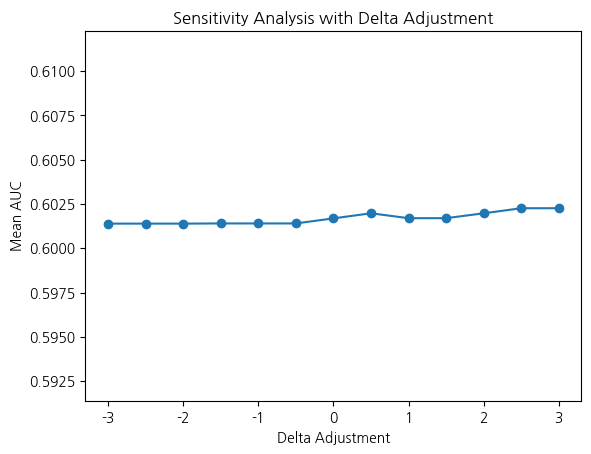

Delta adjustment AUC results: {-3: 0.601392446633826, -2.5: 0.601392446633826, -2: 0.601392446633826, -1.5: 0.6014022988505747, -1.0: 0.6014022988505747, -0.5: 0.6014022988505747, 0: 0.601688013136289, 0.5: 0.601975369458128, 1.0: 0.6016995073891624, 1.5: 0.6016995073891624, 2: 0.601975369458128, 2.5: 0.6022610837438424, 3: 0.6022610837438424}


In [ ]:
target = 'FSS'
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

features = ['Age', 'Sex', '자율신경_활성도', '자율신경_균형도',
            '스트레스_저항도', '스트레스_지수', '평균_심박동수',
            '심장_안정도', 'Sdnn', 'Psi', 'Tp', 'Vlf', 'Lf', 'Hf',
            'LfNorm', 'HfNorm', 'Lf/Hf', 'Rmssd', 'Apen', 'Srd', 'Tsrd',
            'Tp(ln)', 'Vlf(ln)', 'Lf(ln)', 'Hf(ln)']

imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=5, random_state=42),
    max_iter=10,
    random_state=42
)

# Train 데이터에서 Imputer 학습 (fit_transform)
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[features + ['Cortisol(핵의학)']]),
                               columns=features + ['Cortisol(핵의학)'],
                               index=X_train.index)

# Test 데이터는 학습된 imputer로 변환만 수행 (transform)
X_test_imputed = pd.DataFrame(imputer.transform(X_test[features + ['Cortisol(핵의학)']]),
                              columns=features + ['Cortisol(핵의학)'],
                              index=X_test.index)

X_train_imputed['Cortisol_missing'] = X_train['Cortisol(핵의학)'].isna().astype(int)
X_test_imputed['Cortisol_missing'] = X_test['Cortisol(핵의학)'].isna().astype(int)

# Delta Adjustment 적용 함수 (Train 데이터에서만 조정)
def apply_delta_adjustment(X, original_X, delta):
    X_adj = X.copy()
    missing_mask = original_X['Cortisol(핵의학)'].isna()  # 원본에서 결측치 위치 찾기
    X_adj.loc[missing_mask, 'Cortisol(핵의학)'] += delta
    return X_adj

# Delta 값을 조정해 민감도 분석 수행
delta_values = [-3,-2.5,-2,-1.5,-1.0, -0.5, 0, 0.5, 1.0,1.5,2,2.5,3] # delta 값 범위를 넓게 지정해서 모든 경우를 확인
auc_results = {}

features_model = ['Cortisol(핵의학)', 'Cortisol_missing'] + features
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for delta in delta_values:
    # Train 데이터에 Delta 조정 적용
    X_train_delta = apply_delta_adjustment(X_train_imputed, X_train, delta)

    aucs = []
    for train_idx, val_idx in skf.split(X_train_delta, y_train):
        X_train_cv, X_val_cv = X_train_delta.iloc[train_idx], X_train_delta.iloc[val_idx]
        y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        scaler = StandardScaler()
        X_train_cv = scaler.fit_transform(X_train_cv)
        X_val_cv = scaler.transform(X_val_cv)

        model = LogisticRegression(max_iter=10000, random_state=42,solver = 'newton-cg')  
        model.fit(X_train_cv, y_train_cv)
        y_pred = model.predict_proba(X_val_cv)[:, 1]
        aucs.append(roc_auc_score(y_val_cv, y_pred))
    
    auc_results[delta] = np.mean(aucs)

plt.plot(delta_values, list(auc_results.values()), marker='o')
plt.xlabel('Delta Adjustment')
plt.ylabel('Mean AUC')
plt.ylim(min(auc_results.values()) - 0.01, max(auc_results.values()) + 0.01)
plt.title('Sensitivity Analysis with Delta Adjustment')
plt.show()
print("Delta adjustment AUC results:", auc_results)